<a href="https://colab.research.google.com/github/iyashh/Time_Series/blob/main/Final_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Yahoo Finance Data**

In [ ]:
!pip install yfinance


**Calling Yahoo Finance Data**

In [ ]:
import yfinance as yf

# Example: Get historical data for Apple (AAPL)
ticker = yf.Ticker("AAPL")
data_yahoo = ticker.history(period="1mo", interval="1d")  # 1-month daily data

print(data_yahoo.head())


                                 Open        High         Low       Close  \
Date                                                                        
2025-03-17 00:00:00-04:00  213.309998  215.220001  209.970001  214.000000   
2025-03-18 00:00:00-04:00  214.160004  215.149994  211.490005  212.690002   
2025-03-19 00:00:00-04:00  214.220001  218.759995  213.750000  215.240005   
2025-03-20 00:00:00-04:00  213.990005  217.490005  212.220001  214.100006   
2025-03-21 00:00:00-04:00  211.559998  218.839996  211.279999  218.270004   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-03-17 00:00:00-04:00  48073400        0.0           0.0  
2025-03-18 00:00:00-04:00  42432400        0.0           0.0  
2025-03-19 00:00:00-04:00  54385400        0.0           0.0  
2025-03-20 00:00:00-04:00  48862900        0.0           0.0  
2025-03-21 00:00:00-04:00  94127800        0.0           0.0  


**Requsting Alpha Vanatage Data**

In [ ]:
!pip install requests


**Calling Alpha Vanatage Data using API**

In [ ]:
import requests
import pandas as pd

# Replace with your own API key
API_KEY = "680F3Z7GX2XXAOYC"
symbol = "AAPL"
function = "TIME_SERIES_DAILY"

url = f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={API_KEY}&outputsize=compact"

response = requests.get(url)
data_alpha = response.json()

# Convert JSON to DataFrame
df_alpha = pd.DataFrame.from_dict(data_alpha["Time Series (Daily)"], orient="index")
df_alpha = df_alpha.astype(float)
df_alpha.index = pd.to_datetime(df_alpha.index)

print(df_alpha.head())


            1. open   2. high    3. low  4. close    5. volume
2025-04-15  201.855  203.5100  199.8000    202.14   51343872.0
2025-04-14  211.440  212.9400  201.1621    202.52  101352911.0
2025-04-11  186.100  199.5400  186.0600    198.15   87435915.0
2025-04-10  189.065  194.7799  183.0000    190.42  121879981.0
2025-04-09  171.950  200.6100  171.8900    198.85  184395885.0


**Yahoo Finance Dataset Preprocessing**

In [ ]:
# Step 1: Handle missing values
data_yahoo = data_yahoo.ffill().interpolate()

# Step 2: Feature Engineering
# Rolling statistics
data_yahoo['Rolling_Mean_20'] = data_yahoo['Close'].rolling(window=20).mean()
data_yahoo['Rolling_STD_20'] = data_yahoo['Close'].rolling(window=20).std()

# Bollinger Bands
data_yahoo['Upper_Band'] = data_yahoo['Rolling_Mean_20'] + 2 * data_yahoo['Rolling_STD_20']
data_yahoo['Lower_Band'] = data_yahoo['Rolling_Mean_20'] - 2 * data_yahoo['Rolling_STD_20']

# RSI (14-day)
delta = data_yahoo['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
data_yahoo['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = data_yahoo['Close'].ewm(span=12, adjust=False).mean()
exp2 = data_yahoo['Close'].ewm(span=26, adjust=False).mean()
data_yahoo['MACD'] = exp1 - exp2
data_yahoo['Signal_Line'] = data_yahoo['MACD'].ewm(span=9, adjust=False).mean()

# Step 4: Normalize features
# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler # Importing the necessary class

scaler = MinMaxScaler()
scaled_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Signal_Line']
data_yahoo[scaled_cols] = scaler.fit_transform(data_yahoo[scaled_cols])

# Step 5: Split into train/test (80/20)
split_index = int(len(data_yahoo) * 0.8)
yahoo_train = data_yahoo.iloc[:split_index]
yahoo_test = data_yahoo.iloc[split_index:]

# Print the results
print("Data after preprocessing:")
print(data_yahoo.head())  # Display the first 5 rows of preprocessed data

print("\nTrain set summary:")
print(yahoo_train.describe())  # Summary statistics of the training set

print("\nTest set summary:")
print(yahoo_test.describe())  # Summary statistics of the test set

print("\nData shapes:")
print(f"Training data shape: {yahoo_train.shape}")
print(f"Test data shape: {yahoo_test.shape}")

Data after preprocessing:
                               Open      High       Low     Close    Volume  \
Date                                                                          
2025-03-17 00:00:00-04:00  0.802172  0.705216  0.786721  0.807849  0.090758   
2025-03-18 00:00:00-04:00  0.818658  0.703231  0.816059  0.782398  0.053134   
2025-03-19 00:00:00-04:00  0.819822  0.805556  0.859680  0.831941  0.132858   
2025-03-20 00:00:00-04:00  0.815361  0.769558  0.830149  0.809792  0.096024   
2025-03-21 00:00:00-04:00  0.768231  0.807823  0.812005  0.890810  0.397931   

                           Dividends  Stock Splits  Rolling_Mean_20  \
Date                                                                  
2025-03-17 00:00:00-04:00        0.0           0.0              NaN   
2025-03-18 00:00:00-04:00        0.0           0.0              NaN   
2025-03-19 00:00:00-04:00        0.0           0.0              NaN   
2025-03-20 00:00:00-04:00        0.0           0.0              N

**Alpha Vantage Dataset Preprocessing**

In [ ]:
# Fill missing values
df_alpha = df_alpha.ffill().interpolate()

# Rolling stats
# Accessing the close column using its actual name '4. close'
df_alpha['Rolling_Mean_20'] = df_alpha['4. close'].rolling(window=20).mean()
df_alpha['Rolling_STD_20'] = df_alpha['4. close'].rolling(window=20).std()
df_alpha['Upper_Band'] = df_alpha['Rolling_Mean_20'] + 2 * df_alpha['Rolling_STD_20']
df_alpha['Lower_Band'] = df_alpha['Rolling_Mean_20'] - 2 * df_alpha['Rolling_STD_20']

# RSI
# Accessing the close column using its actual name '4. close'
delta = df_alpha['4. close'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
df_alpha['RSI'] = 100 - (100 / (1 + rs))

# MACD
# Accessing the close column using its actual name '4. close'
exp1 = df_alpha['4. close'].ewm(span=12, adjust=False).mean()
exp2 = df_alpha['4. close'].ewm(span=26, adjust=False).mean()
df_alpha['MACD'] = exp1 - exp2
df_alpha['Signal_Line'] = df_alpha['MACD'].ewm(span=9, adjust=False).mean()

# Normalize
# Updating scaled_cols to match Alpha Vantage column names
scaled_cols_alpha = ['1. open', '2. high', '3. low', '4. close', '5. volume', 'RSI', 'MACD', 'Signal_Line']
df_alpha[scaled_cols_alpha] = scaler.fit_transform(df_alpha[scaled_cols_alpha])

# Split
split_index = int(len(df_alpha) * 0.8)
alpha_train = df_alpha.iloc[:split_index]
alpha_test = df_alpha.iloc[split_index:]

# Print the results

# Display the first 5 rows of the preprocessed data
print("Data after preprocessing:")
print(df_alpha.head())  # Display the first 5 rows of the dataframe

# Summary statistics of the training set
print("\nTrain set summary:")
print(alpha_train.describe())  # Summary statistics of the training set

# Summary statistics of the test set
print("\nTest set summary:")
print(alpha_test.describe())  # Summary statistics of the test set

# Display the shapes of the training and test sets
print("\nData shapes:")
print(f"Training data shape: {alpha_train.shape}")
print(f"Test data shape: {alpha_test.shape}")

Data after preprocessing:
             1. open   2. high    3. low  4. close  5. volume  \
2025-04-15  0.346765  0.188848  0.345962  0.343187   0.174416   
2025-04-14  0.457908  0.324016  0.361367  0.347575   0.484721   
2025-04-11  0.164077  0.131943  0.190567  0.297113   0.398366   
2025-04-10  0.198458  0.063712  0.155959  0.207852   0.612091   
2025-04-09  0.000000  0.147280  0.030309  0.305196   1.000000   

            Rolling_Mean_20  Rolling_STD_20  Upper_Band  Lower_Band  RSI  \
2025-04-15              NaN             NaN         NaN         NaN  NaN   
2025-04-14              NaN             NaN         NaN         NaN  NaN   
2025-04-11              NaN             NaN         NaN         NaN  NaN   
2025-04-10              NaN             NaN         NaN         NaN  NaN   
2025-04-09              NaN             NaN         NaN         NaN  NaN   

                MACD  Signal_Line  
2025-04-15  0.317332     0.218836  
2025-04-14  0.319613     0.219405  
2025-04-11  0.2951

**Step-by-step Preprocessing with Sentiment from Headlines**

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00


**Fetching and Analyzing Apple News Headlines**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Function to fetch Apple stock news headlines from Yahoo Finance
def get_apple_news():
    url = "https://finance.yahoo.com/quote/AAPL/news/"
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.text, 'html.parser')

    headlines = []
    for item in soup.find_all('h3'):
        headlines.append(item.get_text())

    return headlines[:500]  # Limit to 500 headlines for performance

# Function to perform sentiment analysis using both TextBlob and VADER
def analyze_sentiment(headlines):
    analyzer = SentimentIntensityAnalyzer()
    df = pd.DataFrame(headlines, columns=['Headline'])

    # TextBlob sentiment analysis
    df['TextBlob_Sentiment'] = df['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # VADER sentiment analysis
    df['VADER_Sentiment'] = df['Headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    return df

# Fetch Apple news headlines
apple_news = get_apple_news()

# Perform sentiment analysis
sentiment_df = analyze_sentiment(apple_news)

# Display the results
print(sentiment_df)


                                             Headline  TextBlob_Sentiment  \
0                                                News            0.000000   
1                                                Life            0.000000   
2                                       Entertainment            0.000000   
3                                             Finance            0.000000   
4                                              Sports            0.000000   
5                                        New on Yahoo            0.136364   
6   Television could go the way of newspapers if t...            0.000000   
7   Trump promises 'expedited' process for Nvidia'...            0.250000   
8   Got $2,000 to Invest? This Is 1 of the Smartes...            0.000000   
9   Here's Why Apple (AAPL) Fell More Than Broader...            0.500000   
10  When Apple's Tim Cook Revealed The Real Reason...            0.100000   
11  Is Apple Inc. (AAPL) The Best American Tech St...            0.500000   

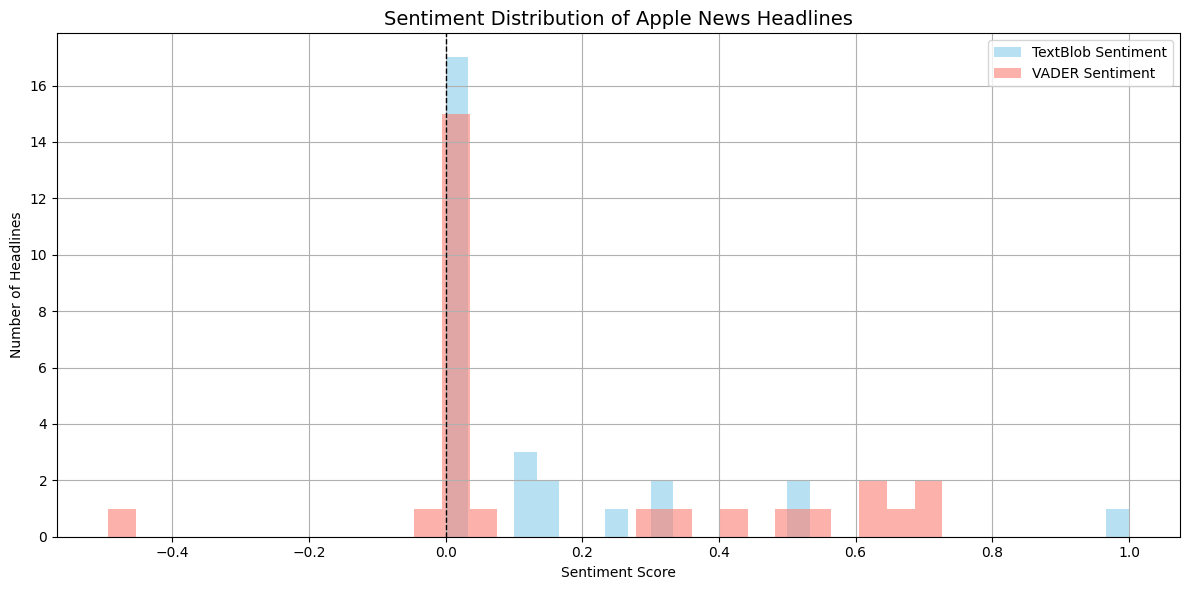

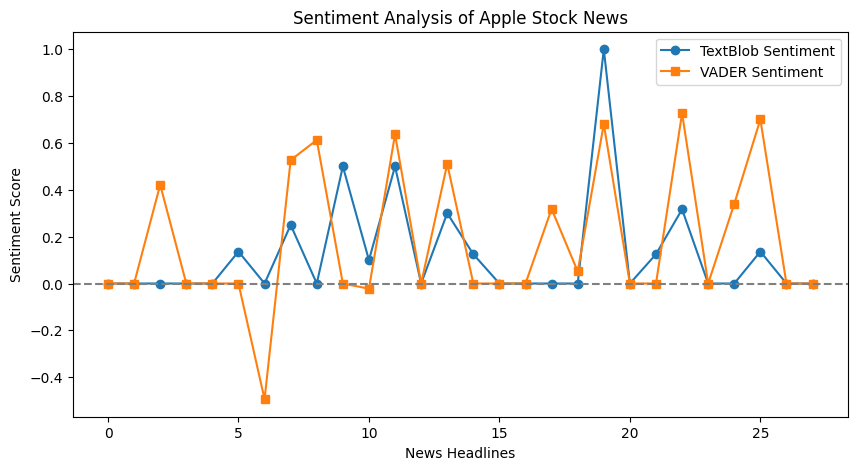

In [ ]:
# Plot: TextBlob vs VADER Sentiment Scores
plt.figure(figsize=(12, 6))
plt.hist(sentiment_df['TextBlob_Sentiment'], bins=30, alpha=0.6, color='skyblue', label='TextBlob Sentiment')
plt.hist(sentiment_df['VADER_Sentiment'], bins=30, alpha=0.6, color='salmon', label='VADER Sentiment')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Sentiment Distribution of Apple News Headlines', fontsize=14)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Headlines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sentiment_df.index, sentiment_df['TextBlob_Sentiment'], marker='o', label='TextBlob Sentiment')
plt.plot(sentiment_df.index, sentiment_df['VADER_Sentiment'], marker='s', label='VADER Sentiment')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("News Headlines")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of Apple Stock News")
plt.legend()
plt.show()

**Required Libraries**

In [ ]:
import seaborn as sns

**✅ EDA for Yahoo Finance Dataset (data_yahoo)**

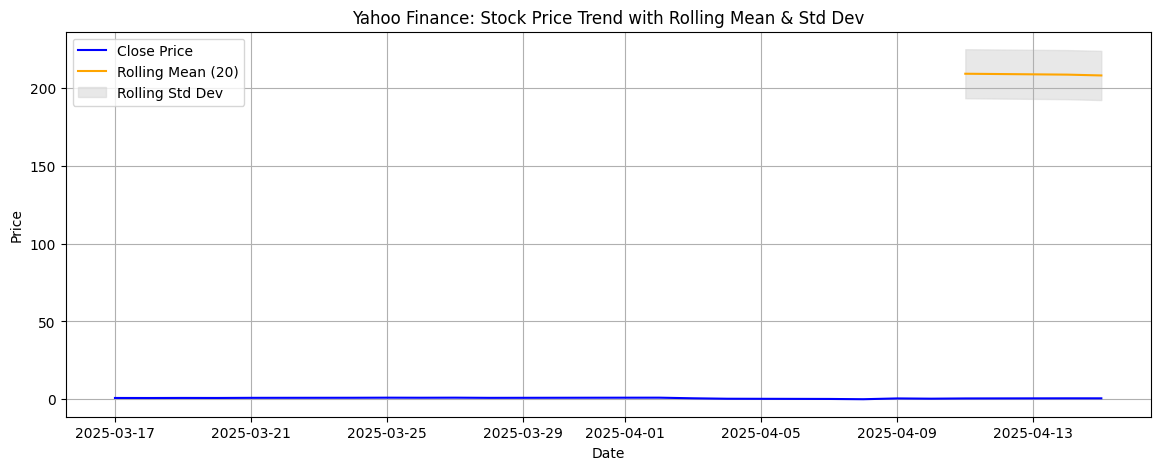

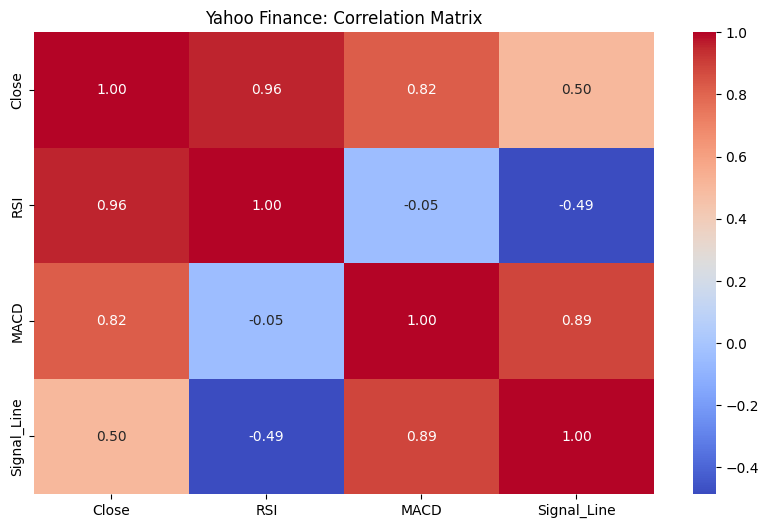

In [ ]:
# === 1. Stock Price Trend Analysis ===
plt.figure(figsize=(14, 5))
plt.plot(data_yahoo.index, data_yahoo['Close'], label='Close Price', color='blue')
plt.plot(data_yahoo.index, data_yahoo['Rolling_Mean_20'], label='Rolling Mean (20)', color='orange')
plt.fill_between(data_yahoo.index,
                 data_yahoo['Rolling_Mean_20'] - data_yahoo['Rolling_STD_20'],
                 data_yahoo['Rolling_Mean_20'] + data_yahoo['Rolling_STD_20'],
                 color='lightgray', alpha=0.5, label='Rolling Std Dev')
plt.title("Yahoo Finance: Stock Price Trend with Rolling Mean & Std Dev")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


# === 2. Correlation Analysis ===
plt.figure(figsize=(10, 6))
corr = data_yahoo[['Close', 'RSI', 'MACD', 'Signal_Line']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Yahoo Finance: Correlation Matrix")
plt.show()


**✅ EDA for Alpha Vantage Dataset (df_alpha)**

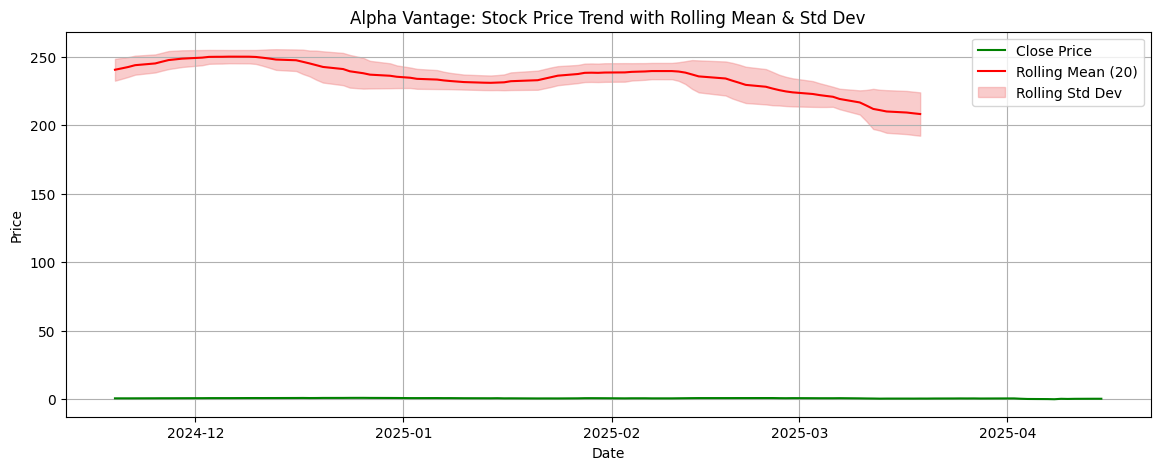

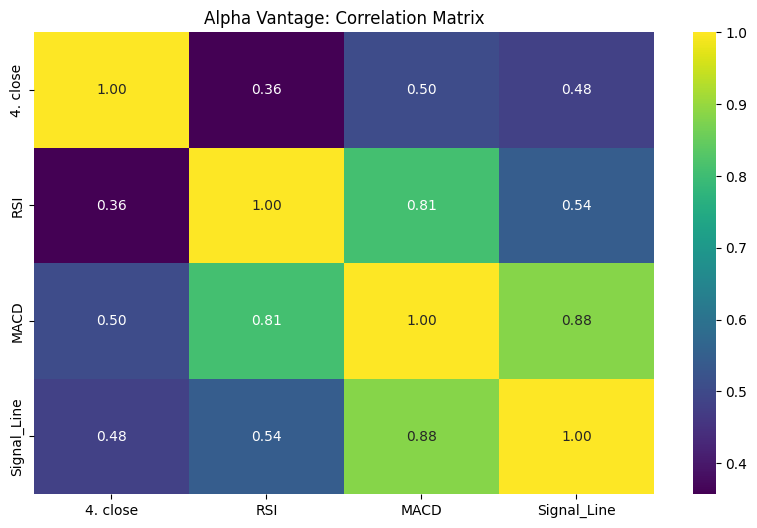

In [ ]:
# === 1. Stock Price Trend Analysis ===
plt.figure(figsize=(14, 5))
# Changed '4. Close' to '4. close'
plt.plot(df_alpha.index, df_alpha['4. close'], label='Close Price', color='green')
plt.plot(df_alpha.index, df_alpha['Rolling_Mean_20'], label='Rolling Mean (20)', color='red')
plt.fill_between(df_alpha.index,
                 df_alpha['Rolling_Mean_20'] - df_alpha['Rolling_STD_20'],
                 df_alpha['Rolling_Mean_20'] + df_alpha['Rolling_STD_20'],
                 color='lightcoral', alpha=0.4, label='Rolling Std Dev')
plt.title("Alpha Vantage: Stock Price Trend with Rolling Mean & Std Dev")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# === 2. Correlation Analysis ===
plt.figure(figsize=(10, 6))
# Changed 'Close' to '4. close' to match the actual column name
corr_alpha = df_alpha[['4. close', 'RSI', 'MACD', 'Signal_Line']].corr()
sns.heatmap(corr_alpha, annot=True, cmap='viridis', fmt=".2f")
plt.title("Alpha Vantage: Correlation Matrix")
plt.show()

# **📈 Traditional Time Series Models**

**1. ARIMA (AutoRegressive Integrated Moving Average)**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

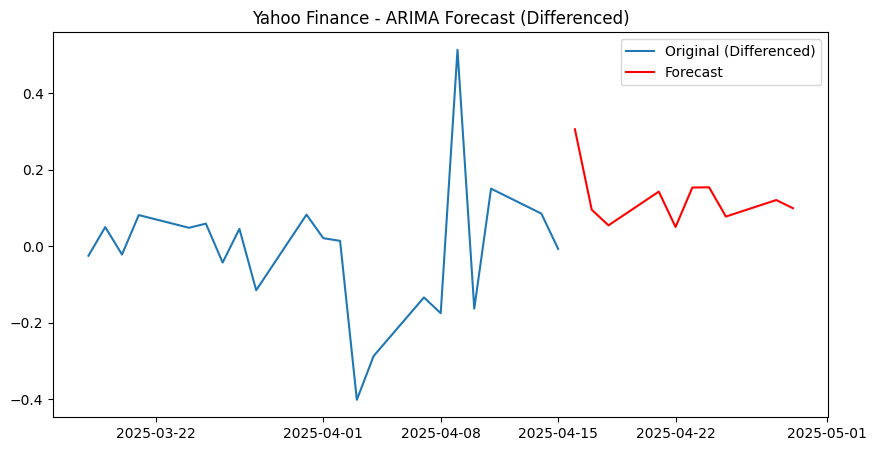

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   21
Model:                 ARIMA(5, 1, 2)   Log Likelihood                   7.332
Date:                Wed, 16 Apr 2025   AIC                              1.336
Time:                        11:38:38   BIC                              9.302
Sample:                    03-18-2025   HQIC                             2.891
                         - 04-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9103      1.421     -0.641      0.522      -3.695       1.874
ar.L2         -0.8469      0.814     -1.040      0.298      -2.443       0.749
ar.L3         -0.6437      1.040     -0.619      0.5

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

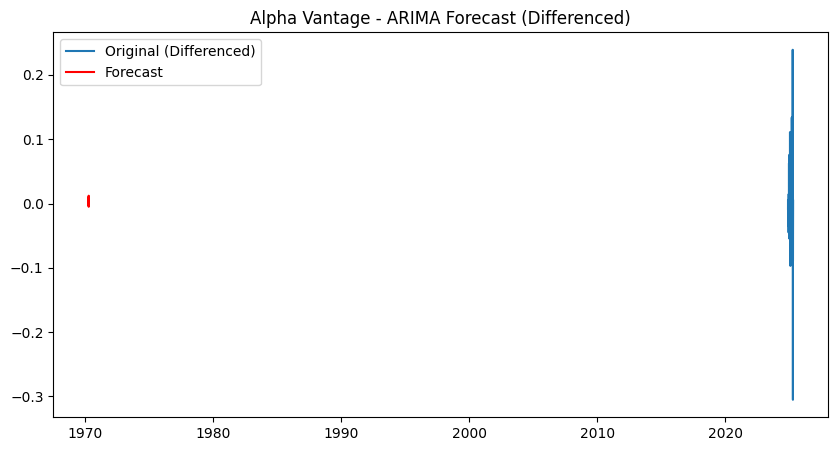

                               SARIMAX Results                                
Dep. Variable:               4. close   No. Observations:                   99
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 136.525
Date:                Wed, 16 Apr 2025   AIC                           -257.049
Time:                        11:38:41   BIC                           -236.369
Sample:                             0   HQIC                          -248.684
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8877      0.151     -5.861      0.000      -1.185      -0.591
ar.L2          0.2101      0.117      1.794      0.073      -0.019       0.440
ar.L3          0.1230      0.158      0.780      0.4

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def run_arima_model(data, title="ARIMA Model", close_col='Close'):
    """
    Runs an ARIMA model on the provided data after taking the difference.

    Args:
        data (pd.DataFrame): The input data containing the time series.
        title (str, optional): The title for the plot. Defaults to "ARIMA Model".
        close_col (str, optional): The name of the column containing the closing price.
                                    Defaults to 'Close'.

    """
    series = data[close_col]  # Access the closing price column using close_col

    # Take the first difference of the series
    series_diff = series.diff().dropna()

    model = ARIMA(series_diff, order=(5, 1, 2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=10)

    plt.figure(figsize=(10, 5))
    plt.plot(series_diff, label='Original (Differenced)')  # Plot differenced series
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.title(f"{title} Forecast (Differenced)")
    plt.legend()
    plt.show()
    print(model_fit.summary())

# For Yahoo Finance data
run_arima_model(data_yahoo, title="Yahoo Finance - ARIMA")

# For Alpha Vantage data
run_arima_model(df_alpha, title="Alpha Vantage - ARIMA", close_col='4. close')

**2. SARIMA (Seasonal ARIMA)**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


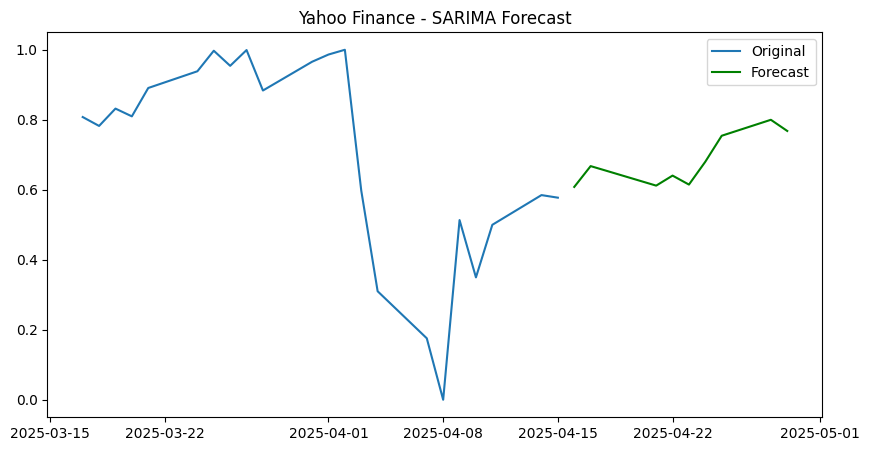

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   22
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -0.696
Date:                            Wed, 16 Apr 2025   AIC                             11.392
Time:                                    11:38:48   BIC                             12.378
Sample:                                03-17-2025   HQIC                             9.264
                                     - 04-15-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8419      5.102     -0.165      0.869     -10.842       9.158
ma.L1          0.6747      4.012   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

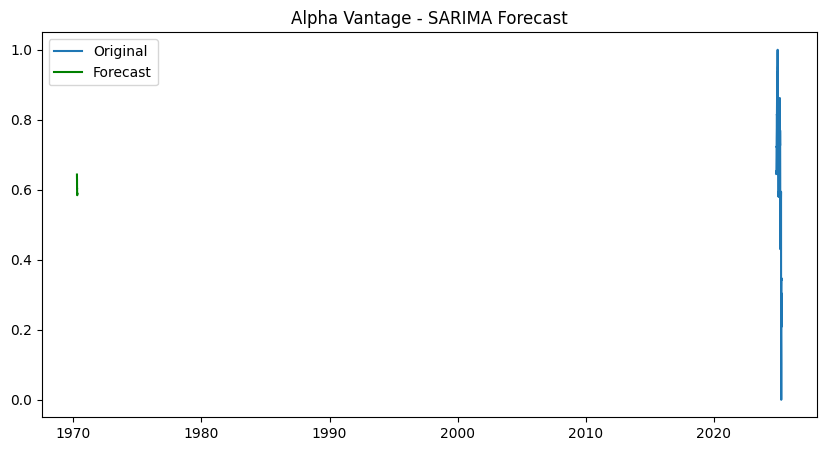

                                     SARIMAX Results                                      
Dep. Variable:                           4. close   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 103.811
Date:                            Wed, 16 Apr 2025   AIC                           -197.623
Time:                                    11:38:52   BIC                           -185.293
Sample:                                         0   HQIC                          -192.658
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5718      0.727     -0.787      0.431      -1.996       0.853
ma.L1          0.4959      0.787   

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def run_sarima_model(data, title="SARIMA Model", close_col='Close'): # Added close_col as argument
    series = data[close_col]
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=10)

    plt.figure(figsize=(10, 5))
    plt.plot(series, label='Original')
    plt.plot(forecast.index, forecast, label='Forecast', color='green')
    plt.title(f"{title} Forecast")
    plt.legend()
    plt.show()
    print(model_fit.summary())

# Call the function with the correct close_col for df_alpha
run_sarima_model(data_yahoo, title="Yahoo Finance - SARIMA")
run_sarima_model(df_alpha, title="Alpha Vantage - SARIMA", close_col='4. close')

**3. VAR (Vector AutoRegression)**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


      Close    Volume
0  0.012008  0.683878
1 -0.379092 -0.273786
2  0.149436  0.236389
3 -0.375843 -0.107339
4  0.264717  0.242560
5 -0.165904  0.155221
6 -0.058938 -0.491044
7  0.290755  0.527394
8 -0.324553 -0.647291
9  0.350983  0.630093


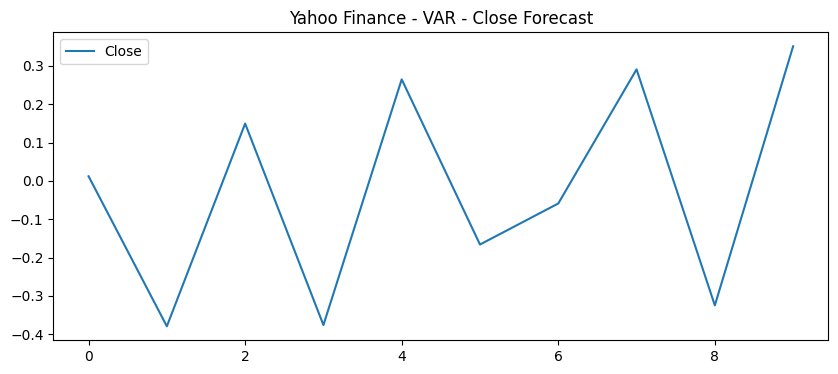

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


   4. close  5. volume
0  0.010313   0.009898
1 -0.003043  -0.008733
2  0.007113  -0.004804
3  0.004345  -0.008283
4  0.005534  -0.002342
5  0.004197  -0.005283
6  0.004217  -0.004137
7  0.004519  -0.004910
8  0.004379  -0.004547
9  0.004545  -0.004636


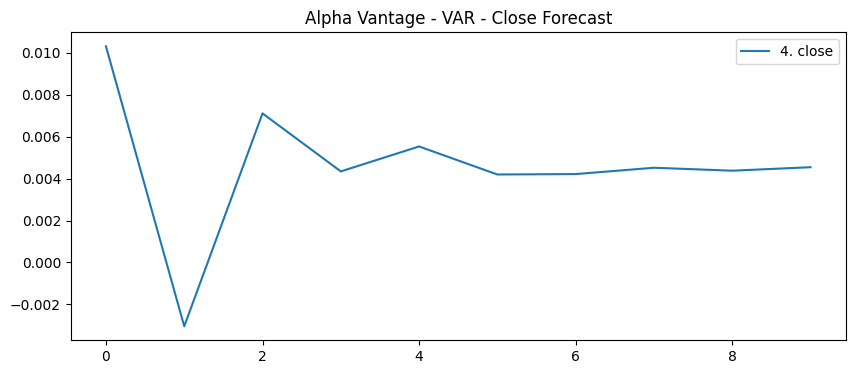

In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import pandas as pd

def run_var_model(data, title="VAR Model", close_col='Close', volume_col='Volume'): # Add arguments for column names
    df = data[[close_col, volume_col]].dropna() # Use provided column names
    df_diff = df.diff().dropna()

    if len(df_diff) < 10:
        print(f"Not enough data to fit VAR model for {title}.")
        return

    try:
        model = VAR(df_diff)
        model_fit = model.fit(ic='aic')  # Automatically determine maxlags using AIC
        forecast = model_fit.forecast(df_diff.values[-model_fit.k_ar:], steps=10)

        forecast_df = pd.DataFrame(forecast, columns=df.columns)
        print(forecast_df)

        forecast_df[[close_col]].plot(title=f"{title} - Close Forecast", figsize=(10, 4)) # Use close_col for plotting
        plt.show()

    except ValueError as e:
        print(f"VAR model failed for {title}: {e}")

# Use the function for both datasets, providing correct column names for df_alpha
run_var_model(data_yahoo, title="Yahoo Finance - VAR")
run_var_model(df_alpha, title="Alpha Vantage - VAR", close_col='4. close', volume_col='5. volume') # Provide column names for df_alpha

**4. GARCH (Volatility Forecasting)**

In [ ]:
!pip install arch
from arch import arch_model

def run_garch_model(data, title="GARCH Model", close_col='Close'): # Added close_col argument
    """
    Runs a GARCH model on the provided data.

    Args:
        data (pd.DataFrame): The input data containing the time series.
        title (str, optional): The title for the model output. Defaults to "GARCH Model".
        close_col (str, optional): The name of the column containing the closing price.
                                    Defaults to 'Close'.

    """
    returns = 100 * data[close_col].pct_change().dropna() # Use close_col to access closing price

    # Replace infinite values with NaN
    returns = returns.replace([np.inf, -np.inf], np.nan)

    # Drop rows with NaN values
    returns = returns.dropna()

    model = arch_model(returns, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')
    forecast = model_fit.forecast(horizon=5)

    print(model_fit.summary())
    print("\nForecast Variance:")
    print(forecast.variance[-1:])

# Import numpy
import numpy as np # Importing numpy for using np.inf, np.nan

run_garch_model(data_yahoo, title="Yahoo Finance - GARCH")
run_garch_model(df_alpha, title="Alpha Vantage - GARCH", close_col='4. close') # Pass '4. close' for Alpha Vantage

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -90.4408
Distribution:                  Normal   AIC:                           188.882
Method:            Maximum Likelihood   BIC:                           192.864
                                        No. Observations:                   20
Date:                Wed, Apr 16 2025   Df Residuals:                       19
Time:                        11:38:59   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3327      3.754  8.862e-02      0.929 [ -7.026,  7.69

# **🤖 Machine Learning Models**

**Step 1: Create Supervised Features**

In [ ]:
def create_lag_features(df, lags=5, close_col='Close'): # Added close_col argument
    data = df[[close_col]].copy() # Use close_col to select the closing price column
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = data[close_col].shift(i) # Use close_col to shift the correct column
    data.dropna(inplace=True)
    return data

# Apply transformation
yahoo_ml = create_lag_features(data_yahoo)
# Pass '4. close' as the close_col argument for df_alpha
alpha_ml = create_lag_features(df_alpha, close_col='4. close')

**Step 2: Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_data(df, close_col='Close'): # Added close_col argument
    X = df.drop(close_col, axis=1) # Use close_col to drop the correct column
    y = df[close_col] # Use close_col to select the correct column for y
    return train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_y, X_test_y, y_train_y, y_test_y = prepare_data(yahoo_ml)
X_train_a, X_test_a, y_train_a, y_test_a = prepare_data(alpha_ml, close_col='4. close') # Pass '4. close' for alpha_ml

**1. Random Forest Regressor**

Yahoo - Random Forest MSE: 0.02


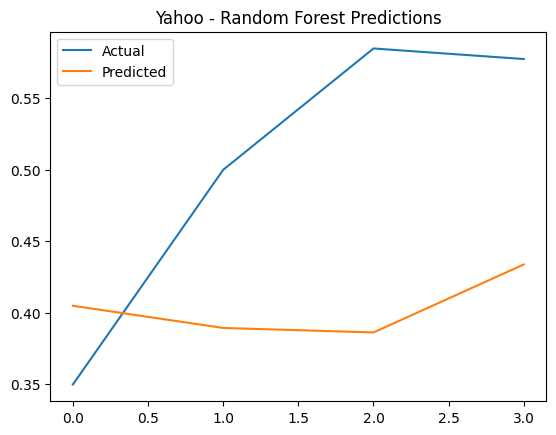

Alpha Vantage - Random Forest MSE: 0.00


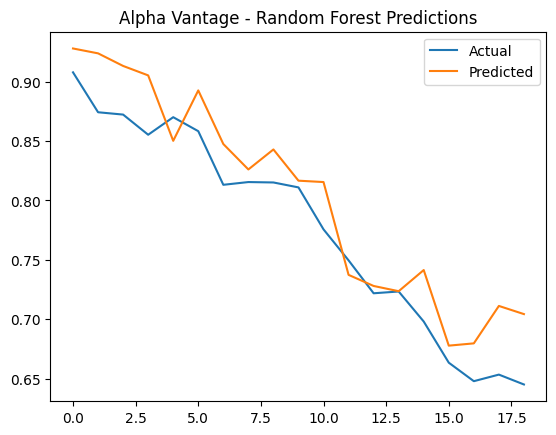

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def run_rf(X_train, X_test, y_train, y_test, title="Random Forest"):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"{title} MSE: {mse:.2f}")
    plt.plot(y_test.values, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.title(f"{title} Predictions")
    plt.legend()
    plt.show()

run_rf(X_train_y, X_test_y, y_train_y, y_test_y, title="Yahoo - Random Forest")
run_rf(X_train_a, X_test_a, y_train_a, y_test_a, title="Alpha Vantage - Random Forest")


**2. XGBoost Regressor**

Yahoo - XGBoost MSE: 0.04


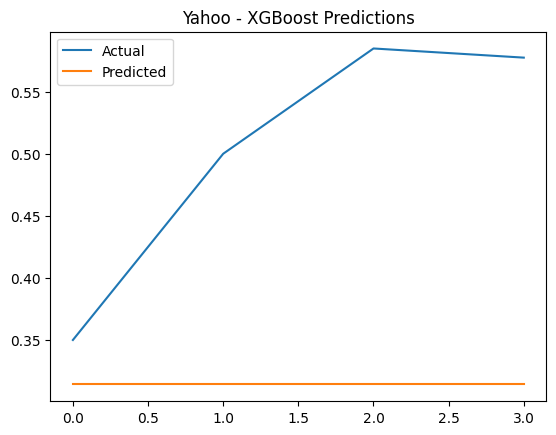

Alpha Vantage - XGBoost MSE: 0.00


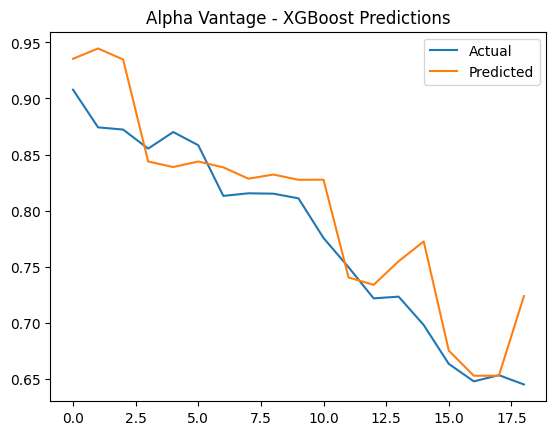

In [ ]:
from xgboost import XGBRegressor

def run_xgb(X_train, X_test, y_train, y_test, title="XGBoost"):
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"{title} MSE: {mse:.2f}")
    plt.plot(y_test.values, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.title(f"{title} Predictions")
    plt.legend()
    plt.show()

run_xgb(X_train_y, X_test_y, y_train_y, y_test_y, title="Yahoo - XGBoost")
run_xgb(X_train_a, X_test_a, y_train_a, y_test_a, title="Alpha Vantage - XGBoost")


**3. Support Vector Regressor (SVR)**

Yahoo - SVR MSE: 0.01


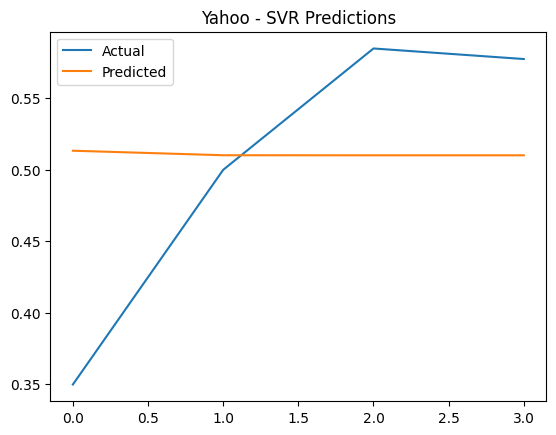

Alpha Vantage - SVR MSE: 0.00


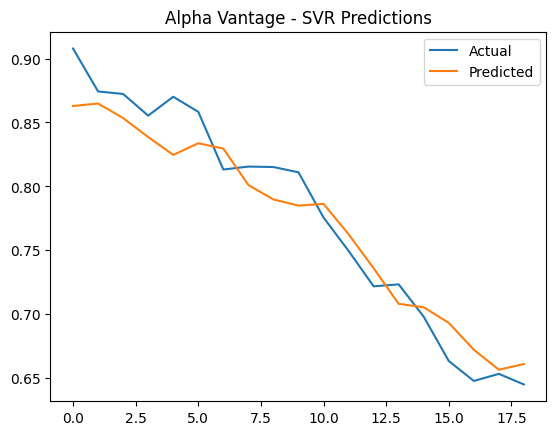

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def run_svr(X_train, X_test, y_train, y_test, title="SVR"):
    model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"{title} MSE: {mse:.2f}")
    plt.plot(y_test.values, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.title(f"{title} Predictions")
    plt.legend()
    plt.show()

run_svr(X_train_y, X_test_y, y_train_y, y_test_y, title="Yahoo - SVR")
run_svr(X_train_a, X_test_a, y_train_a, y_test_a, title="Alpha Vantage - SVR")


# **📈 Deep Learning Models**

**Step 1: Data Preparation**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Example: Get historical data for Apple (AAPL)
ticker = yf.Ticker("AAPL")
data_yahoo = ticker.history(period="1mo", interval="1d")  # 1-month daily data

def preprocess_seq_data(df, n_steps=10):
    data = df[['Close']].dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i-n_steps:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 3D for RNN input
    return X, y, scaler

# Prepare Yahoo & Alpha datasets
X_yahoo, y_yahoo, scaler_yahoo = preprocess_seq_data(data_yahoo)
# Assuming df_alpha is defined somewhere else in your notebook
df_alpha = yf.download("AAPL", period="1mo", interval="1d")

X_alpha, y_alpha, scaler_alpha = preprocess_seq_data(df_alpha) #Assuming df_alpha is defined in your notebook

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


**Step 2: Model Trainer Function**

In [ ]:
def split_seq_data(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:]

X_train_y, X_test_y, y_train_y, y_test_y = split_seq_data(X_yahoo, y_yahoo)
X_train_a, X_test_a, y_train_a, y_test_a = split_seq_data(X_alpha, y_alpha)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Bidirectional, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error # Importing mean_squared_error

def train_and_plot(model, X_train, y_train, X_test, y_test, title):
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"{title} MSE: {mse:.4f}")

    plt.plot(y_test, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

**LSTM**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Yahoo - LSTM MSE: 0.0130


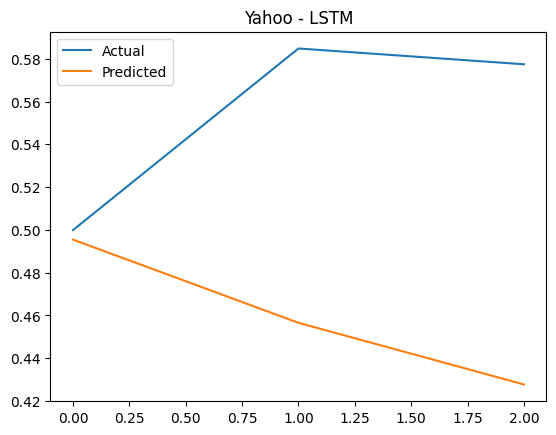

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Alpha - LSTM MSE: 0.0146


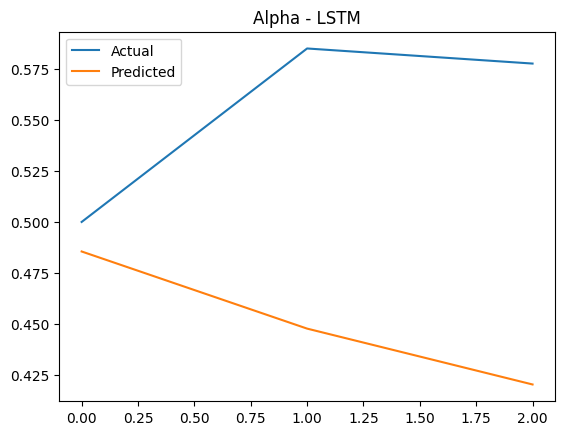

In [ ]:
def run_lstm(X_train, y_train, X_test, y_test, title):
    model = Sequential()
    model.add(LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    train_and_plot(model, X_train, y_train, X_test, y_test, title)

run_lstm(X_train_y, y_train_y, X_test_y, y_test_y, title="Yahoo - LSTM")
run_lstm(X_train_a, y_train_a, X_test_a, y_test_a, title="Alpha - LSTM")


**BiLSTM**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
Yahoo - BiLSTM MSE: 0.0101


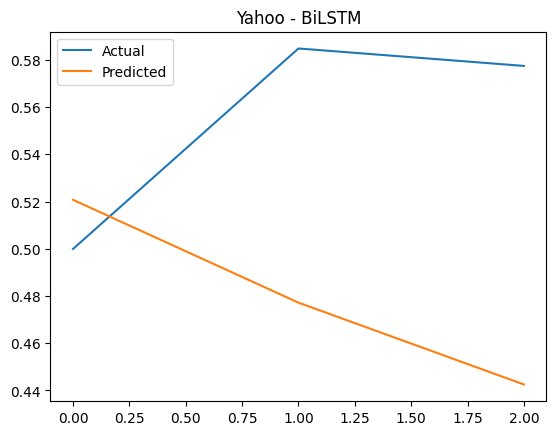

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Alpha - BiLSTM MSE: 0.0232


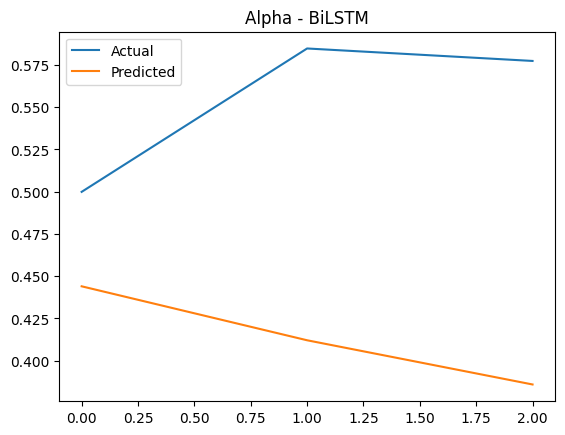

In [ ]:
def run_bilstm(X_train, y_train, X_test, y_test, title):
    model = Sequential()
    model.add(Bidirectional(LSTM(100), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    train_and_plot(model, X_train, y_train, X_test, y_test, title)

run_bilstm(X_train_y, y_train_y, X_test_y, y_test_y, title="Yahoo - BiLSTM")
run_bilstm(X_train_a, y_train_a, X_test_a, y_test_a, title="Alpha - BiLSTM")


**GRU**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Yahoo - GRU MSE: 0.0293


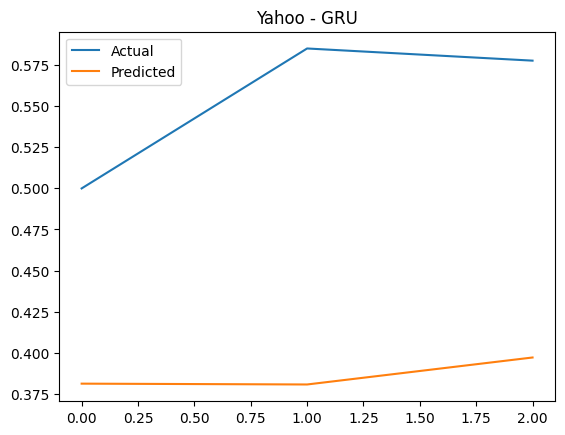

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Alpha - GRU MSE: 0.0243


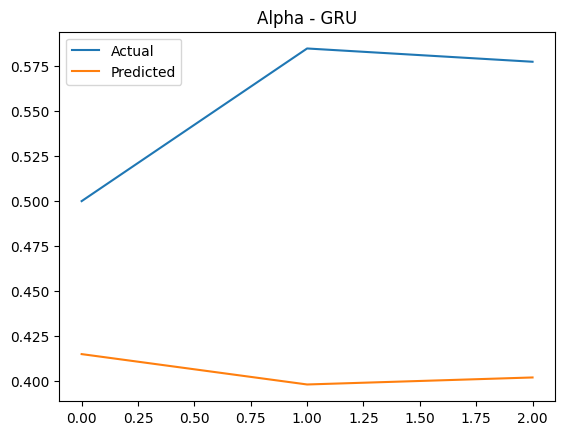

In [ ]:
def run_gru(X_train, y_train, X_test, y_test, title):
    model = Sequential()
    model.add(GRU(100, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    train_and_plot(model, X_train, y_train, X_test, y_test, title)

run_gru(X_train_y, y_train_y, X_test_y, y_test_y, title="Yahoo - GRU")
run_gru(X_train_a, y_train_a, X_test_a, y_test_a, title="Alpha - GRU")


**Transformer**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Yahoo - Transformer MSE: 0.2975


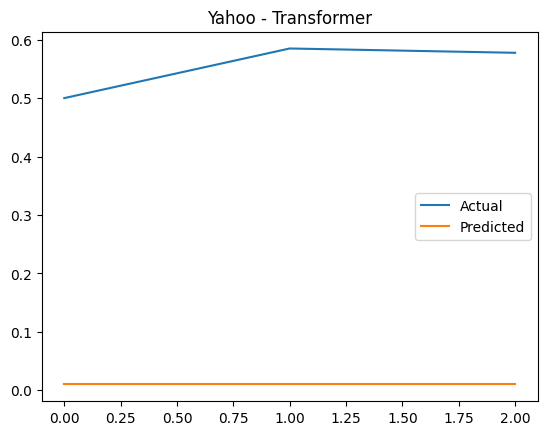

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Alpha - Transformer MSE: 0.2975


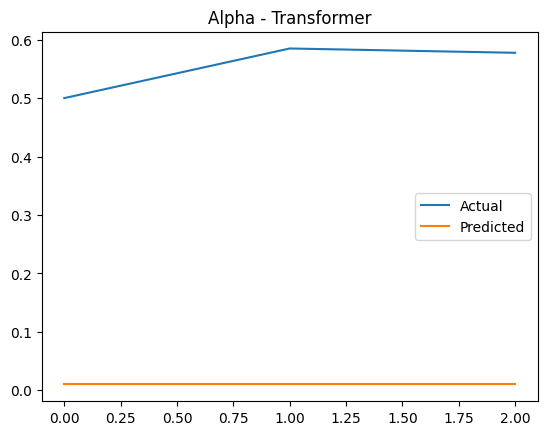

In [ ]:
from keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Flatten

def transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)

    from keras.models import Model
    return Model(inputs, outputs)

def run_transformer(X_train, y_train, X_test, y_test, title):
    model = transformer_model((X_train.shape[1], 1))
    train_and_plot(model, X_train, y_train, X_test, y_test, title)

run_transformer(X_train_y, y_train_y, X_test_y, y_test_y, title="Yahoo - Transformer")
run_transformer(X_train_a, y_train_a, X_test_a, y_test_a, title="Alpha - Transformer")


# **Model Evaluation**

In [ ]:
data_yahoo['Close'].to_csv("yahoo_close.csv")
df_alpha['Close'].to_csv("alpha_close.csv")
from google.colab import files
files.download("yahoo_close.csv")
files.download("alpha_close.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Traditional Models**

<ipython-input-45-e2d9e19a9c71>:103: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  yahoo_close = pd.read_csv("yahoo_close.csv", index_col=0, parse_dates=True).asfreq('D').fillna(method='ffill')
<ipython-input-45-e2d9e19a9c71>:104: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  alpha_close = pd.read_csv("alpha_close.csv", index_col=0, parse_dates=True).asfreq('D').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


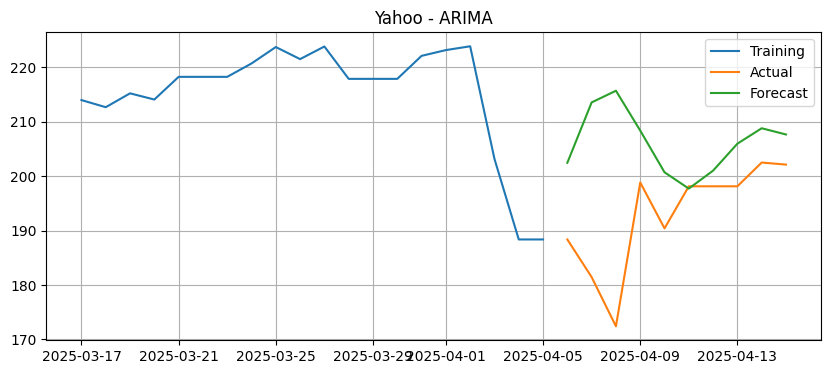

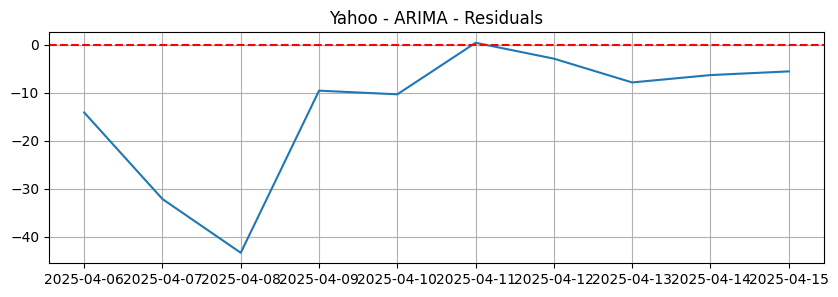

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


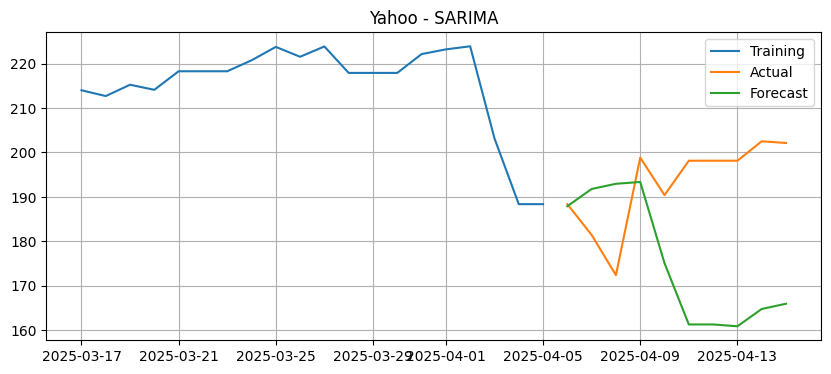

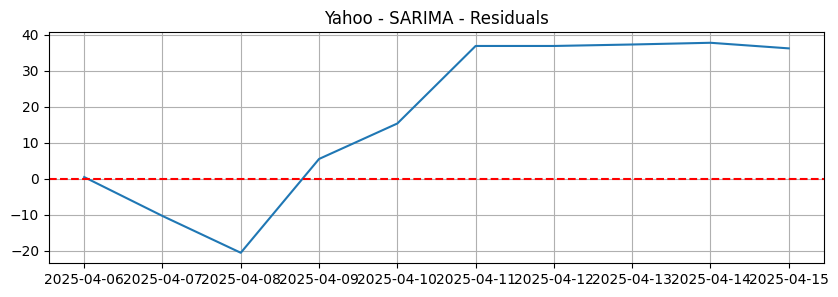

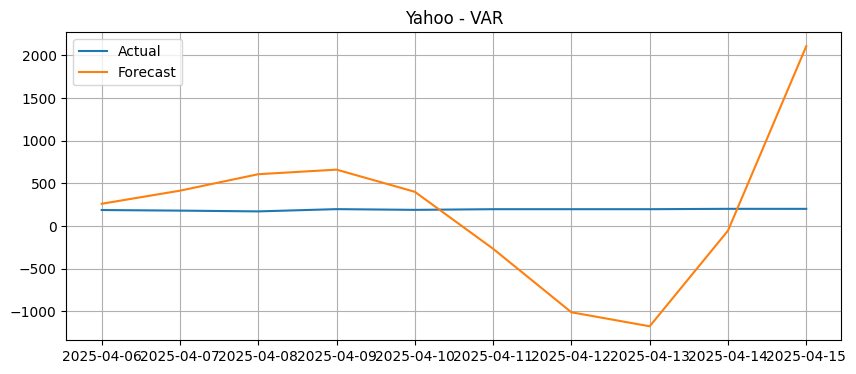

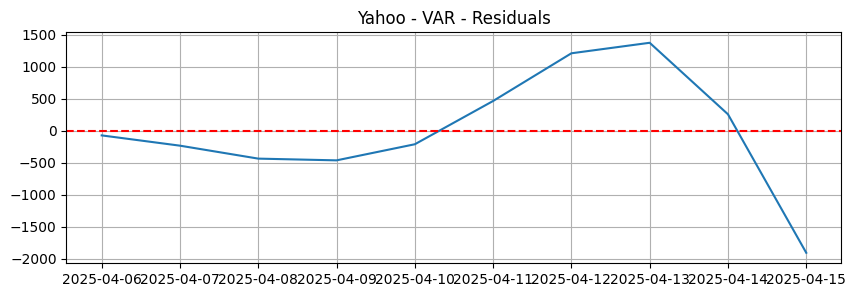

GARCH forecast is empty in Yahoo. Skipping...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


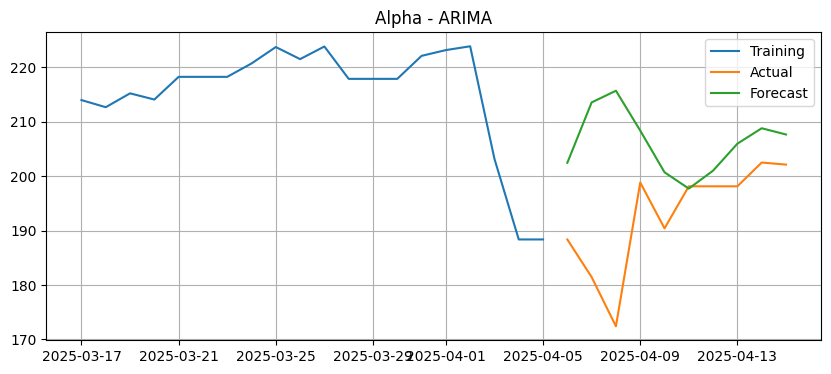

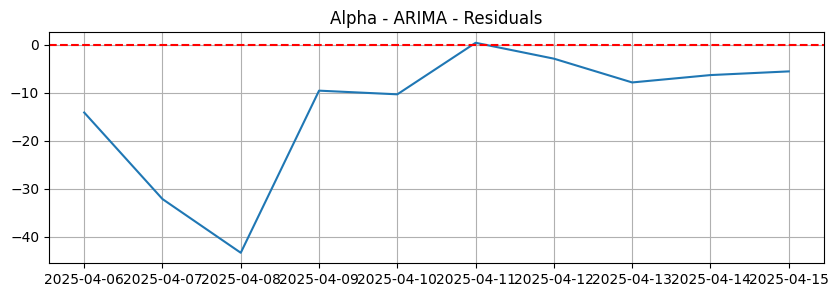

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


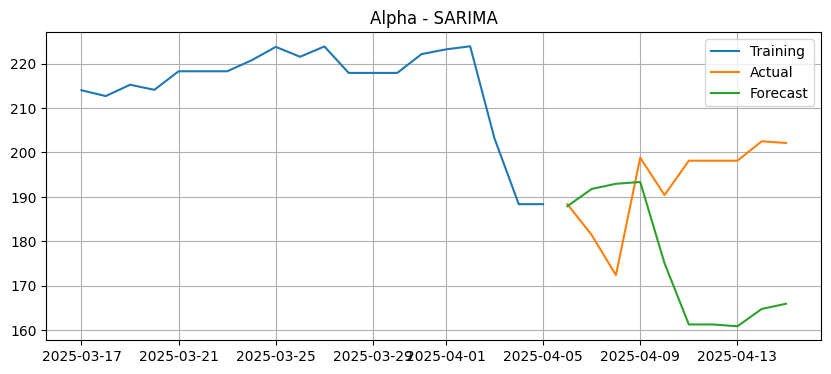

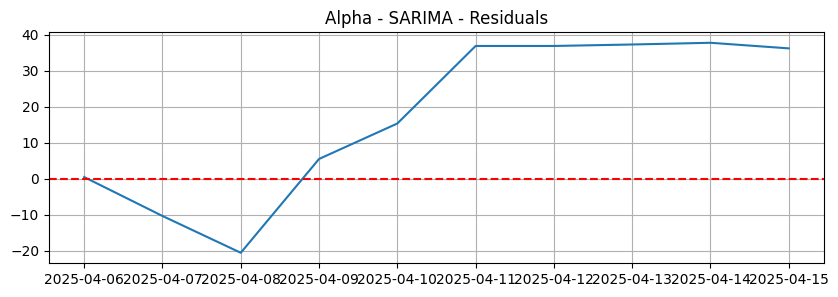

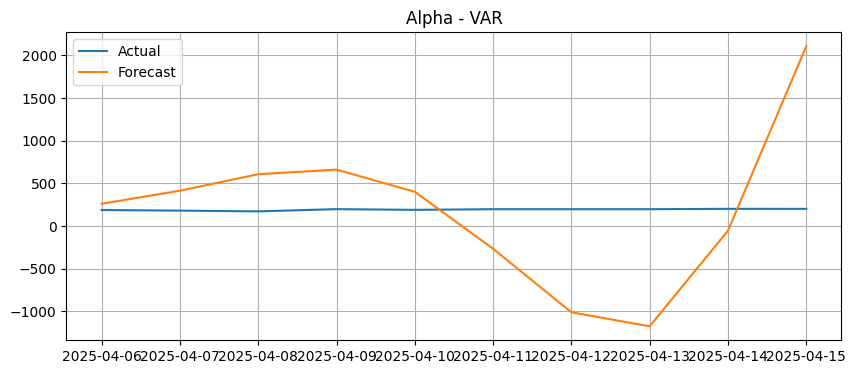

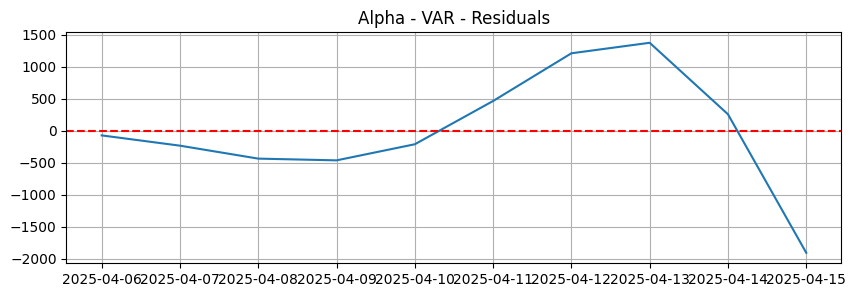

GARCH forecast is empty in Alpha. Skipping...
📈 Yahoo Finance Model Comparison:


,MAE,RMSE,MAPE,R²
ARIMA,13.23,18.55,7.20,-2.94
SARIMA,23.69,27.61,12.11,-7.74
VAR,662.41,881.16,337.03,-8896.75
GARCH,NaN,NaN,NaN,NaN


📊 Alpha Vantage Model Comparison:


,MAE,RMSE,MAPE,R²
ARIMA,13.23,18.55,7.20,-2.94
SARIMA,23.69,27.61,12.11,-7.74
VAR,662.41,881.16,337.03,-8896.75
GARCH,NaN,NaN,NaN,NaN


In [ ]:
!pip install arch
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model  # <- Make sure this is installed via pip install arch

# --- Evaluation ---
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R²": r2}

forecast_days = 10

# --- Models ---
def run_arima_forecast(data, name, order=(5, 1, 0)):
    train = data[:-forecast_days]
    test = data[-forecast_days:]
    model = ARIMA(train, order=order).fit()
    forecast = model.forecast(steps=forecast_days)
    _plot_forecast(train, test, forecast, name + " - ARIMA")
    return evaluate_model(test.values, forecast.values)

def run_sarima_forecast(data, name, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)):
    train = data[:-forecast_days]
    test = data[-forecast_days:]
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    forecast = model.forecast(steps=forecast_days)
    _plot_forecast(train, test, forecast, name + " - SARIMA")
    return evaluate_model(test.values, forecast.values)

def run_var_forecast(data, name, lags=5):
    df = pd.concat([data.shift(i) for i in range(lags + 1)], axis=1).dropna()
    train, test = df[:-forecast_days], df[-forecast_days:]
    model = VAR(train).fit(maxlags=lags)
    forecast_input = train.values[-lags:]
    forecast = model.forecast(y=forecast_input, steps=forecast_days)
    forecast_values = forecast[:, 0]
    actual_values = test.iloc[:, 0].values
    _plot_forecast(test.index, actual_values, forecast_values, name + " - VAR", raw=True)
    return evaluate_model(actual_values, forecast_values)

def run_garch_forecast(data, name, p=1, q=1):
    returns = 100 * data.pct_change().dropna()
    train = returns[:-forecast_days]
    test = returns[-forecast_days:]

    # Check if train data has enough values after dropna()
    if len(train) < 10:  # Or any suitable threshold
        print(f"Insufficient data for GARCH modeling in {name}. Skipping...")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R²": np.nan}

    model = arch_model(train, vol='Garch', p=p, q=q, dist='normal').fit(disp="off")

    # Check if the forecast is empty
    forecast = model.forecast(horizon=1, start=len(train), reindex=False)
    if forecast.mean.empty:
        print(f"GARCH forecast is empty in {name}. Skipping...")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R²": np.nan}

    forecast = forecast.mean['h.1'].values.flatten()

    last_price = data.iloc[-forecast_days - 1]
    forecast_prices = [last_price * (1 + forecast[0] / 100)]
    for r in forecast[1:]:
        forecast_prices.append(forecast_prices[-1] * (1 + r / 100))
    actual = data[-forecast_days:].values.flatten()
    _plot_forecast(data.index[-forecast_days:], actual, forecast_prices, name + " - GARCH", raw=True)
    return evaluate_model(actual, forecast_prices)

# --- Plotting ---
def _plot_forecast(x1, y_actual, y_pred, title, raw=False):
    plt.figure(figsize=(10, 4))
    if not raw:
        plt.plot(x1.index, x1.values, label='Training')
        plt.plot(y_actual.index, y_actual.values, label='Actual')
        plt.plot(y_actual.index, y_pred.values, label='Forecast')
    else:
        plt.plot(x1, y_actual, label='Actual')
        plt.plot(x1, y_pred, label='Forecast')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residual Plot
    residuals = y_actual - y_pred if raw else y_actual.values - y_pred.values
    plt.figure(figsize=(10, 3))
    plt.plot(x1 if raw else y_actual.index, residuals, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{title} - Residuals')
    plt.grid(True)
    plt.show()

# --- Load CSV ---
yahoo_close = pd.read_csv("yahoo_close.csv", index_col=0, parse_dates=True).asfreq('D').fillna(method='ffill')
alpha_close = pd.read_csv("alpha_close.csv", index_col=0, parse_dates=True).asfreq('D').fillna(method='ffill')
yahoo_close.columns = ['Close']
alpha_close.columns = ['Close']

# --- Run All Models ---
datasets = {"Yahoo": yahoo_close['Close'], "Alpha": alpha_close['Close']}
model_metrics = {}

for name, series in datasets.items():
    model_metrics[name] = {
        "ARIMA": run_arima_forecast(series, name),
        "SARIMA": run_sarima_forecast(series, name),
        "VAR": run_var_forecast(pd.DataFrame(series), name),
        "GARCH": run_garch_forecast(series, name)
    }

# --- Summary Tables ---
print("📈 Yahoo Finance Model Comparison:")
display(pd.DataFrame(model_metrics["Yahoo"]).T.round(2))

print("📊 Alpha Vantage Model Comparison:")
display(pd.DataFrame(model_metrics["Alpha"]).T.round(2))


**Machine learning Models**

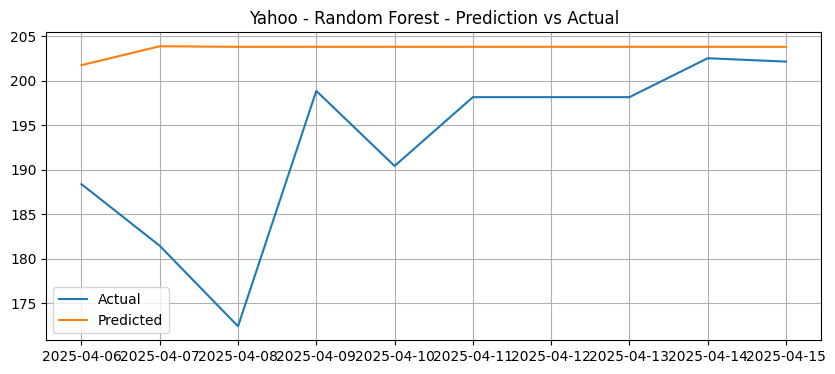

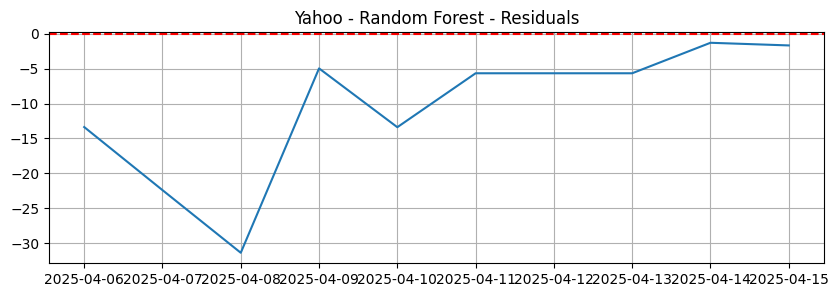

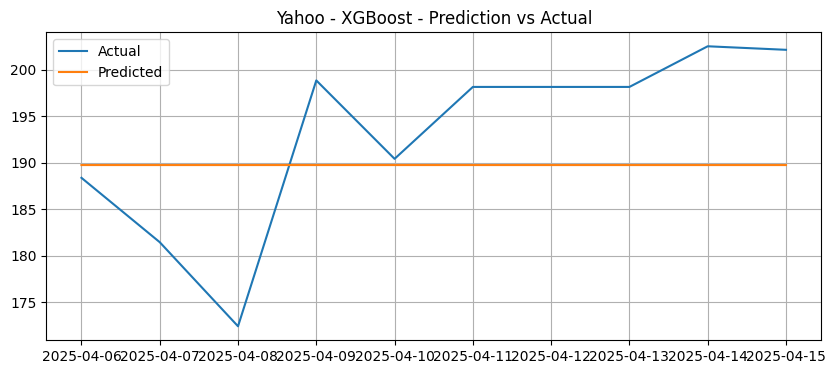

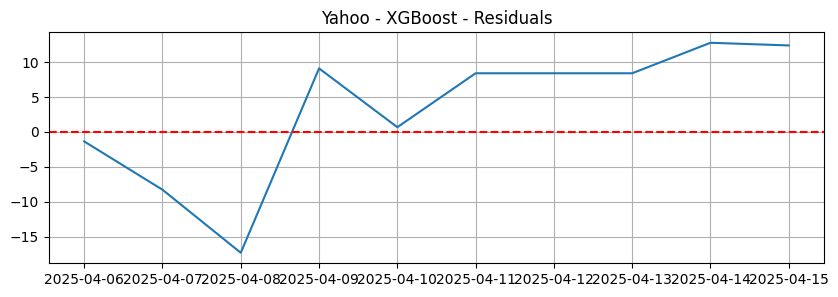

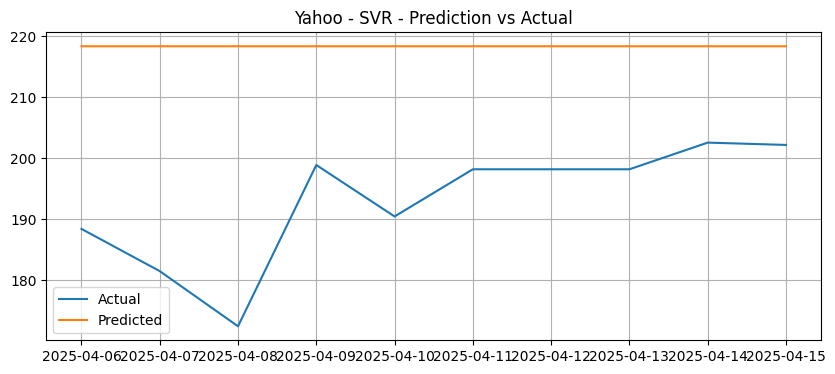

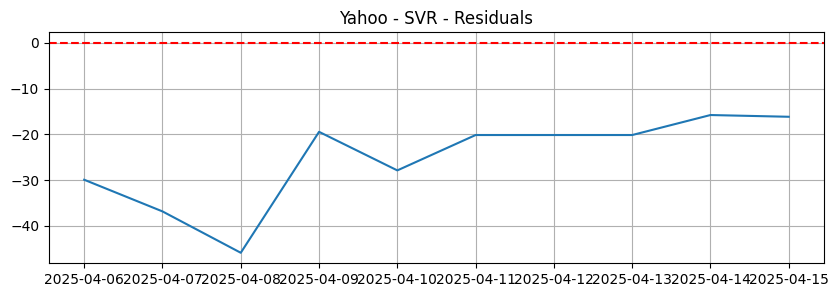

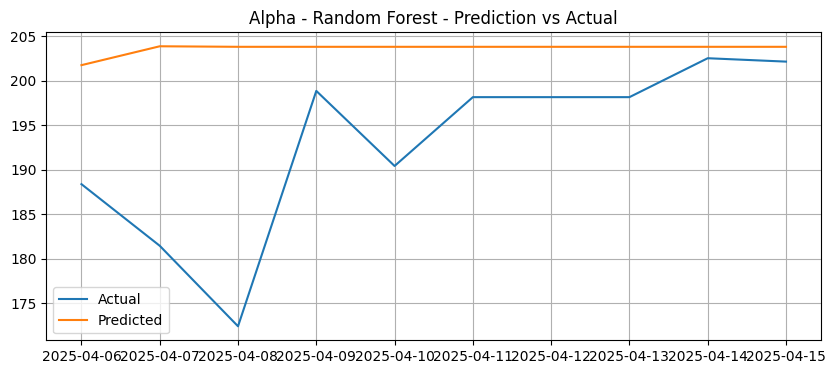

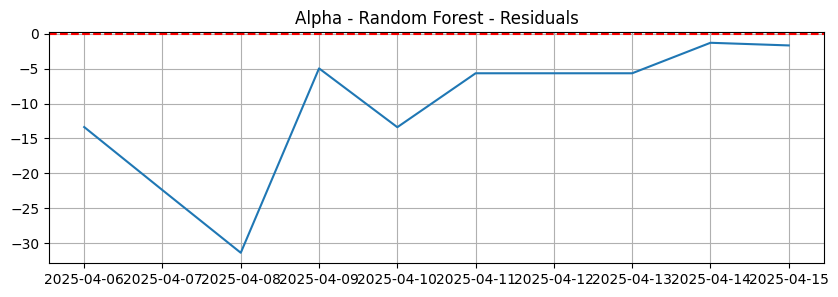

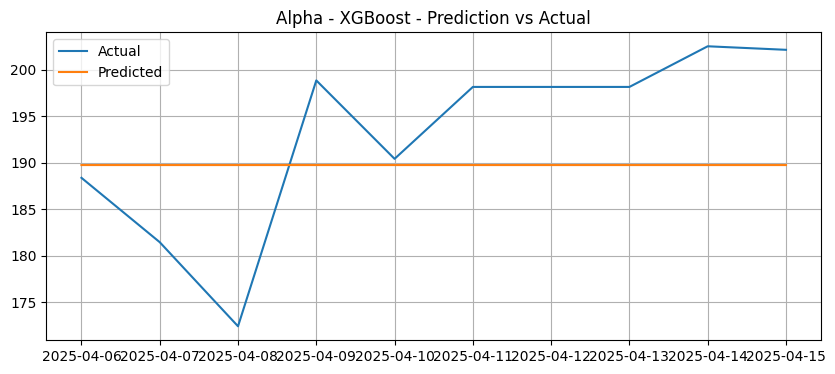

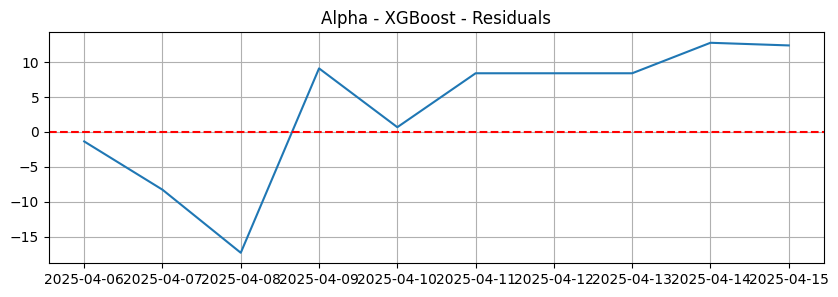

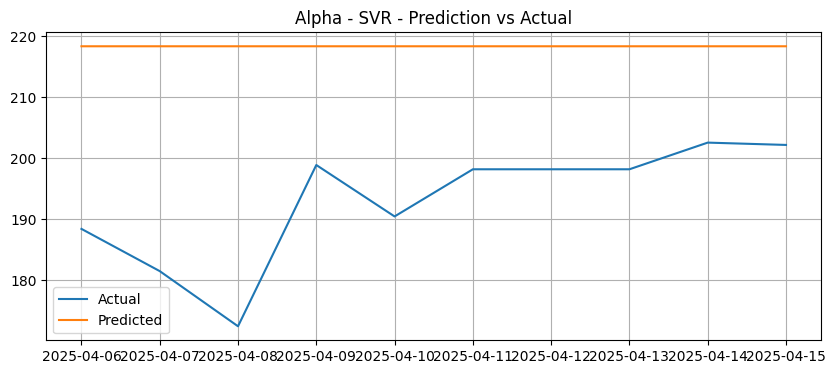

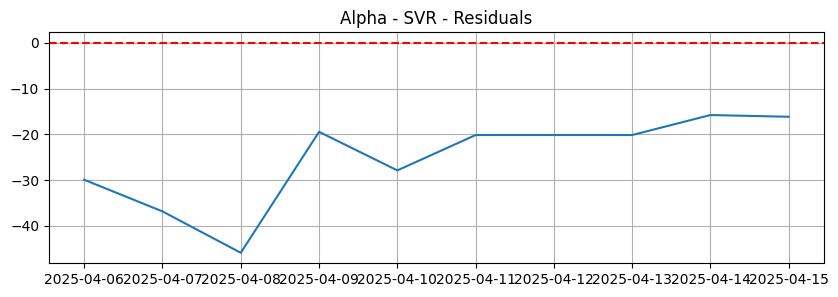

📈 Yahoo Finance ML Model Comparison:


,MAE,RMSE,MAPE,R²
Random Forest,10.54,14.03,5.72,-1.26
XGBoost,8.71,9.91,4.54,-0.13
SVR,25.24,26.92,13.36,-7.30


📊 Alpha Vantage ML Model Comparison:


,MAE,RMSE,MAPE,R²
Random Forest,10.54,14.03,5.72,-1.26
XGBoost,8.71,9.91,4.54,-0.13
SVR,25.24,26.92,13.36,-7.30


In [ ]:
!pip install xgboost scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Reuse Evaluation Function ---
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R²": r2}

def _plot_results(y_test, y_pred, name):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test, label="Actual")
    plt.plot(y_test.index, y_pred, label="Predicted")
    plt.title(f"{name} - Prediction vs Actual")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 3))
    plt.plot(y_test.index, residuals, label="Residuals")
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{name} - Residuals")
    plt.grid(True)
    plt.show()

# --- Features & Targets ---
def create_features(df, lags=5):
    df_feat = pd.DataFrame()
    for i in range(1, lags + 1):
        df_feat[f'lag_{i}'] = df.shift(i)
    df_feat['target'] = df.values
    df_feat = df_feat.dropna()
    return df_feat

# --- ML Model Runner ---
def run_ml_models(df_series, name):
    df_feat = create_features(df_series)
    X = df_feat.drop(columns=['target'])
    y = df_feat['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=forecast_days)

    # Normalize for SVR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(kernel='rbf')
    }

    results = {}
    for model_name, model in models.items():
        if model_name == "SVR":
            model.fit(X_train_scaled, y_train)
            pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)

        pred_series = pd.Series(pred, index=y_test.index)
        _plot_results(y_test, pred_series, f"{name} - {model_name}")
        results[model_name] = evaluate_model(y_test, pred_series)

    return results

# --- Run on Both Datasets ---
ml_metrics = {
    "Yahoo": run_ml_models(yahoo_close['Close'], "Yahoo"),
    "Alpha": run_ml_models(alpha_close['Close'], "Alpha")
}

# --- Summary ---
print("📈 Yahoo Finance ML Model Comparison:")
display(pd.DataFrame(ml_metrics["Yahoo"]).T.round(2))

print("📊 Alpha Vantage ML Model Comparison:")
display(pd.DataFrame(ml_metrics["Alpha"]).T.round(2))


**Deep Learning Models**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


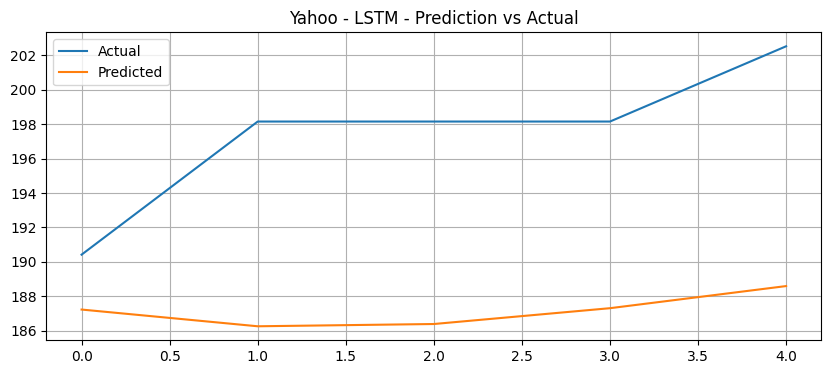

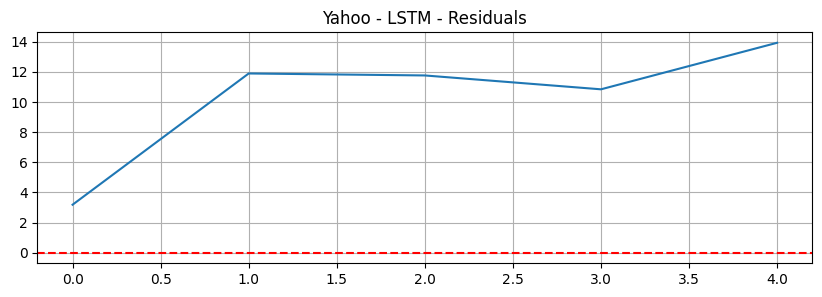

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


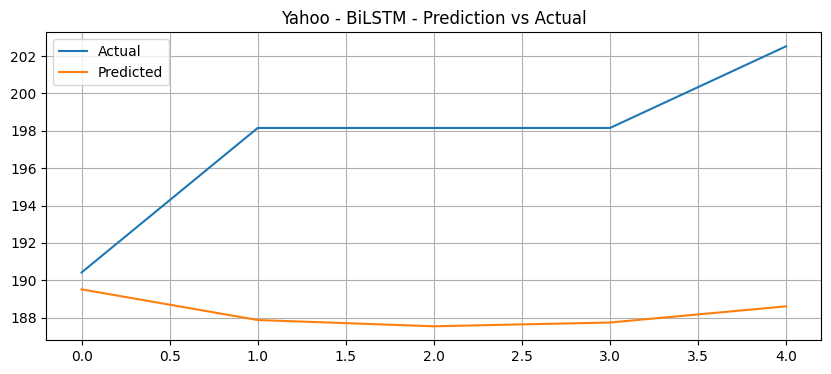

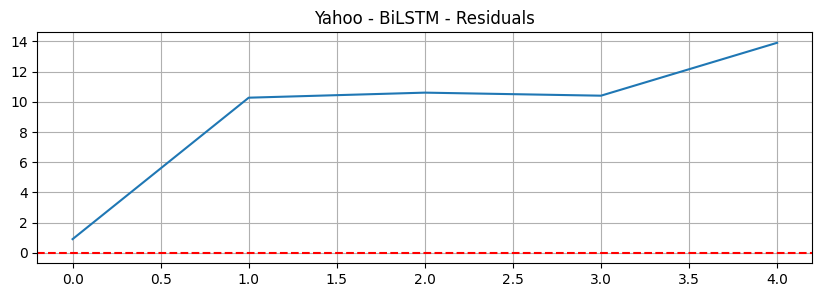

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


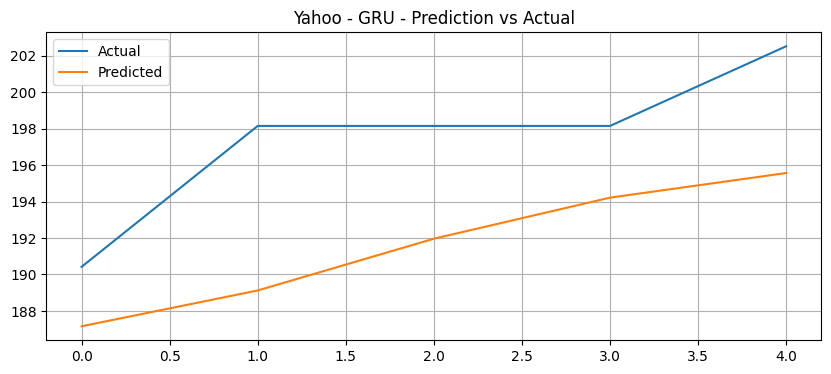

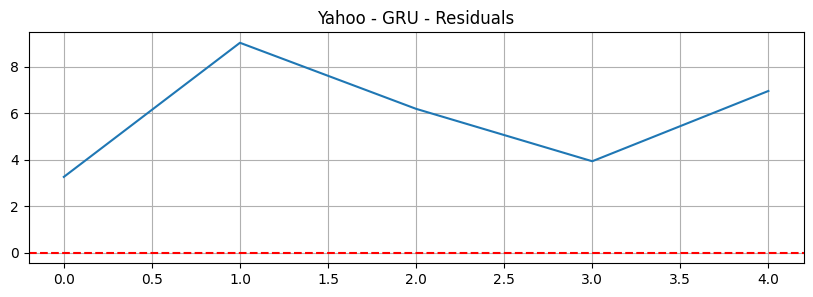

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


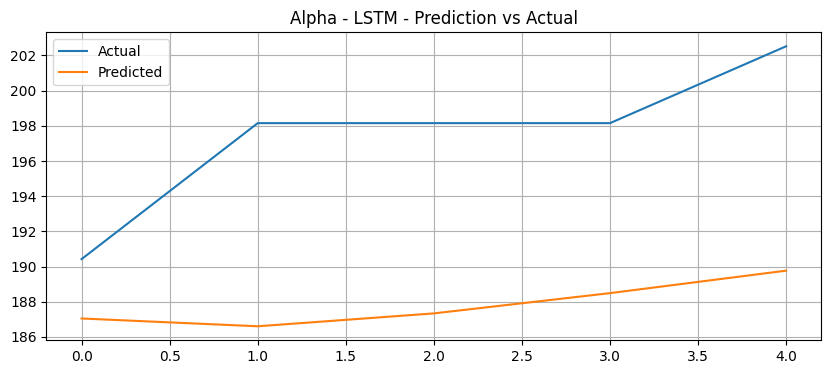

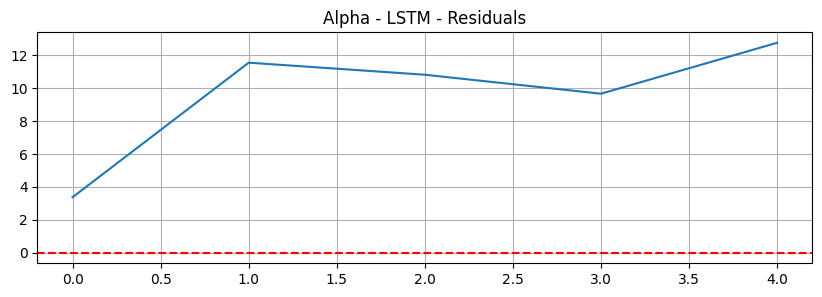

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


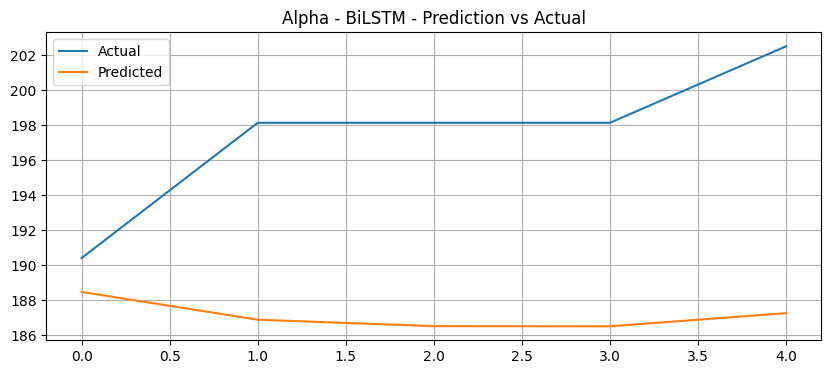

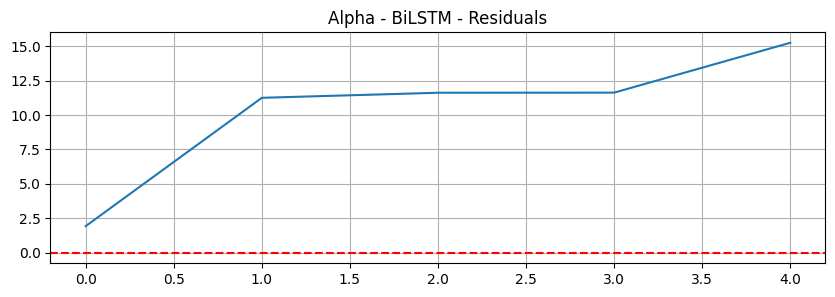

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


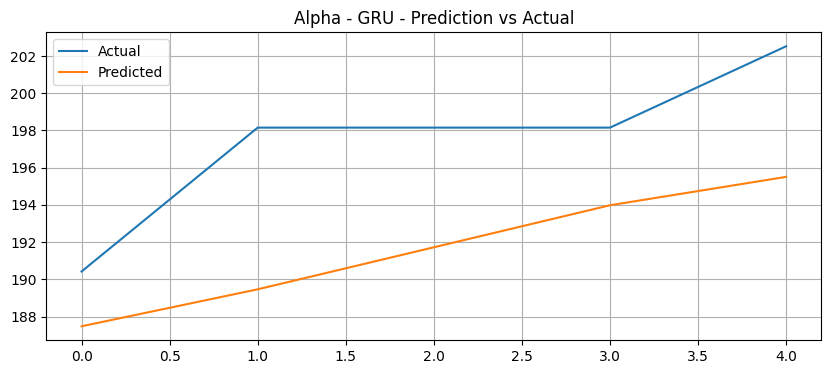

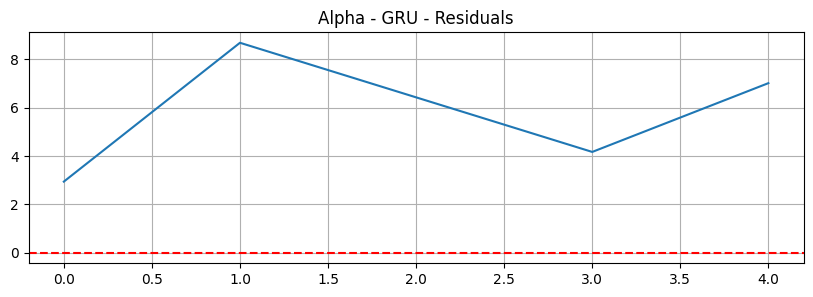

📈 Yahoo Finance Deep Learning Model Comparison:


,MAE,RMSE,MAPE,R²
LSTM,10.32,10.96,5.19,-6.85
BiLSTM,9.22,10.21,4.63,-5.80
GRU,5.87,6.23,2.96,-1.54


📊 Alpha Vantage Deep Learning Model Comparison:


,MAE,RMSE,MAPE,R²
LSTM,9.63,10.18,4.85,-5.76
BiLSTM,10.34,11.25,5.19,-7.27
GRU,5.85,6.20,2.95,-1.51


In [ ]:
# --- Updated Deep Learning Models for Small Datasets ---
seq_length = 10
forecast_days = 5

def train_and_forecast_dl(data_series, name, model_type='LSTM', seq_length=10, hidden_units=100, forecast_days=5):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data_series.values.reshape(-1, 1))

    if len(scaled) < (seq_length + forecast_days + 5):  # small buffer
        print(f"🚫 Insufficient data for {name} - {model_type}. Skipping...")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R²": np.nan}

    X, y = create_sequences(scaled, seq_length)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test, y_test = X[-forecast_days:], y[-forecast_days:]

    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))

    if model_type == 'LSTM':
        model.add(LSTM(hidden_units))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(hidden_units)))
    elif model_type == 'GRU':
        model.add(GRU(hidden_units))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)

    pred = model.predict(X_test)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    pred_rescaled = scaler.inverse_transform(pred).flatten()

    _plot_results(pd.Series(y_test_rescaled), pd.Series(pred_rescaled), f"{name} - {model_type}")
    return evaluate_dl_model(y_test_rescaled, pred_rescaled)

# --- Run Deep Learning Models with updated settings ---
dl_metrics = {}
for name, series in datasets.items():
    dl_metrics[name] = {
        "LSTM": train_and_forecast_dl(series, name, 'LSTM', seq_length=seq_length, forecast_days=forecast_days),
        "BiLSTM": train_and_forecast_dl(series, name, 'BiLSTM', seq_length=seq_length, forecast_days=forecast_days),
        "GRU": train_and_forecast_dl(series, name, 'GRU', seq_length=seq_length, forecast_days=forecast_days),

    }

# --- Summary ---
print("📈 Yahoo Finance Deep Learning Model Comparison:")
display(pd.DataFrame(dl_metrics["Yahoo"]).T.round(2))

print("📊 Alpha Vantage Deep Learning Model Comparison:")
display(pd.DataFrame(dl_metrics["Alpha"]).T.round(2))


**Hybrid Models**

In [ ]:
def run_arima_lstm(data_series, name, seq_length=10, forecast_days=5):
    # Step 1: Fit ARIMA
    train = data_series[:-forecast_days]
    test = data_series[-forecast_days:]
    arima_model = ARIMA(train, order=(5, 1, 0)).fit()
    arima_forecast = arima_model.forecast(steps=forecast_days)

    # Step 2: Get residuals
    residuals = arima_model.resid
    scaler = MinMaxScaler()
    res_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

    if len(res_scaled) < (seq_length + forecast_days + 5):
        print(f"🚫 Insufficient data for {name} - ARIMA-LSTM. Skipping...")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R²": np.nan}

    X_res, y_res = create_sequences(res_scaled, seq_length)
    X_train_res, y_train_res = X_res[:-forecast_days], y_res[:-forecast_days]
    X_test_res = X_res[-forecast_days:]

    # Step 3: Train LSTM on residuals
    model = Sequential([
        Input(shape=(seq_length, 1)),
        LSTM(100),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_res, y_train_res, epochs=30, batch_size=8, verbose=0)

    residual_preds = model.predict(X_test_res).flatten()
    residual_preds_inv = scaler.inverse_transform(residual_preds.reshape(-1, 1)).flatten()

    final_forecast = arima_forecast.values + residual_preds_inv
    actual = test.values

    _plot_results(pd.Series(actual), pd.Series(final_forecast), f"{name} - ARIMA+LSTM")
    return evaluate_model(actual, final_forecast)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape

def run_cnn_lstm(data_series, name, seq_length=10, forecast_days=5):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data_series.values.reshape(-1, 1))

    if len(scaled) < (seq_length + forecast_days + 5):
        print(f"🚫 Insufficient data for {name} - CNN-LSTM. Skipping...")
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan, "R²": np.nan}

    X, y = create_sequences(scaled, seq_length)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test, y_test = X[-forecast_days:], y[-forecast_days:]

    model = Sequential([
        Input(shape=(seq_length, 1)),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(100),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)

    pred = model.predict(X_test).flatten()
    actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    forecast = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

    _plot_results(pd.Series(actual), pd.Series(forecast), f"{name} - CNN+LSTM")
    return evaluate_model(actual, forecast)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


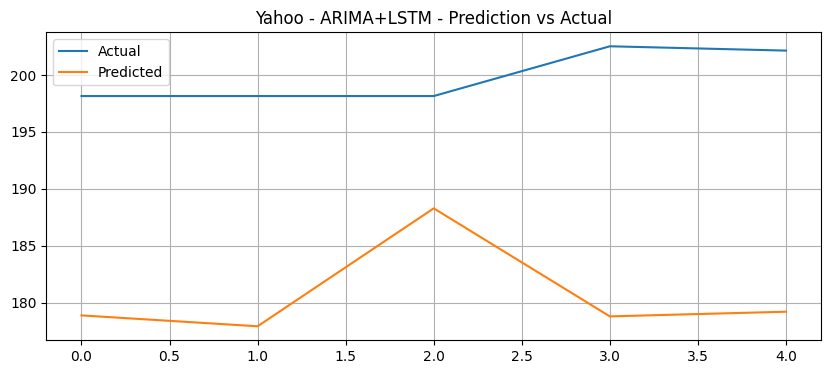

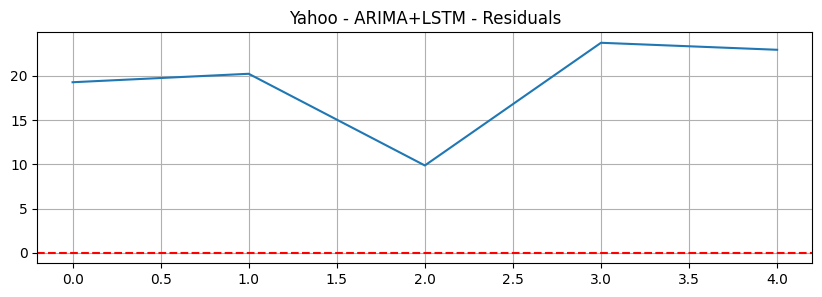

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


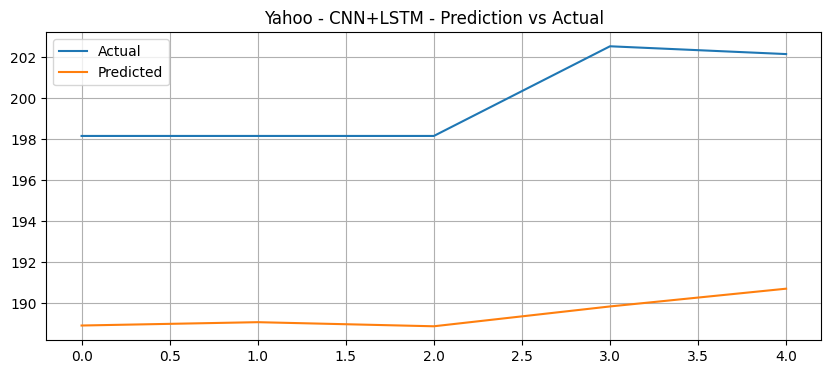

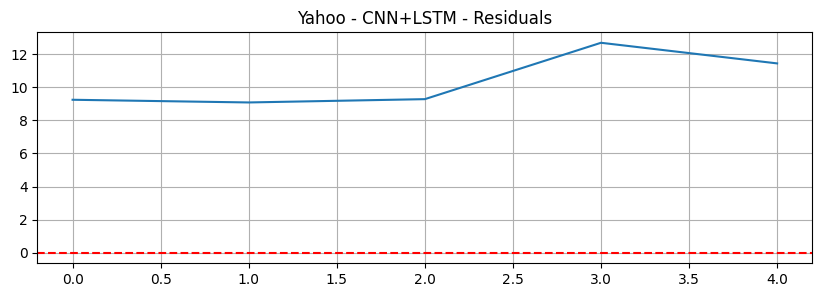

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


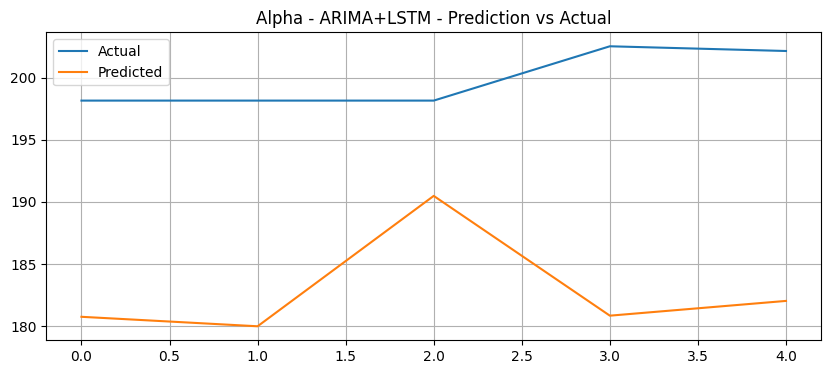

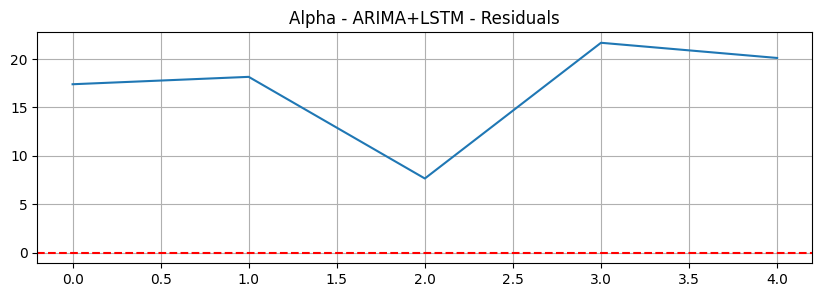

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


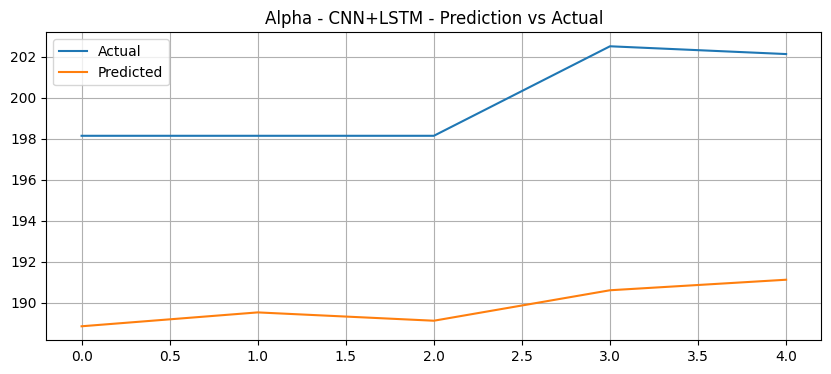

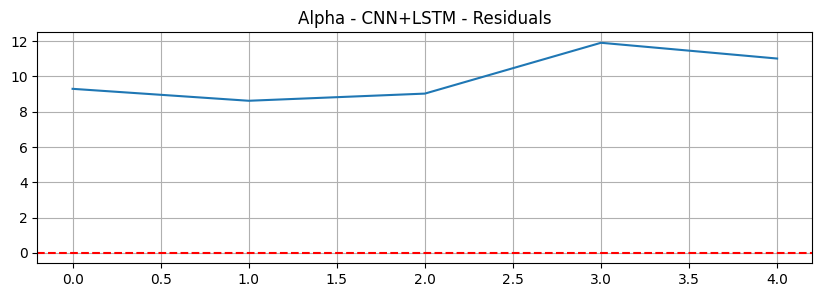

📈 Yahoo Finance Hybrid Models:


,MAE,RMSE,MAPE,R²
ARIMA+LSTM,19.20,19.82,9.59,-92.39
CNN+LSTM,10.34,10.44,5.17,-24.92


📊 Alpha Vantage Hybrid Models:


,MAE,RMSE,MAPE,R²
ARIMA+LSTM,17.00,17.69,8.49,-73.37
CNN+LSTM,9.98,10.06,4.99,-23.03


In [ ]:
hybrid_metrics = {}
for name, series in datasets.items():
    hybrid_metrics[name] = {
        "ARIMA+LSTM": run_arima_lstm(series, name),
        "CNN+LSTM": run_cnn_lstm(series, name)
    }

print("📈 Yahoo Finance Hybrid Models:")
display(pd.DataFrame(hybrid_metrics["Yahoo"]).T.round(2))

print("📊 Alpha Vantage Hybrid Models:")
display(pd.DataFrame(hybrid_metrics["Alpha"]).T.round(2))
